In [176]:
import numpy as np
import pandas as pd
from datetime import datetime

import seaborn as sns
from matplotlib import pyplot as plt

from statsmodels import api as sm
from statsmodels.tsa.seasonal import seasonal_decompose, STL

from statsforecast import StatsForecast
from statsforecast.models import (
    AutoETS,
    HoltWinters,
    SeasonalNaive,
    SimpleExponentialSmoothing
)

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.exponential_smoothing.ets import ETSModel


from sklearn.neighbors import KernelDensity

from sklearn.metrics import mean_squared_error

from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
def plot_ts_resid(df, x, y, n_lags=range(1,10), title=''):
    _, _, = plt.subplots(figsize=(12,7))
    ax0 = plt.subplot2grid((2, 2), (0, 0), colspan=2)
    ax1 = plt.subplot2grid((2, 2), (1, 0))
    ax2 = plt.subplot2grid((2, 2), (1, 1));

    ax0.plot(df[y], marker='o', color='k',)
    #ax0.hlines(0, 2000, df['Resid'].shape[0], color='k', linestyle='--')

    plot_acf(df[y], ax=ax1, lags=n_lags)

    ax2.hist(df[y], bins=len(df) // 4)

    ax0.set_title(title)
    for axi in [ax0, ax1, ax2]: axi.grid('on')

    plt.tight_layout();

#### 1. Consider the the number of pigs slaughtered in Victoria, available in the aus_livestock dataset.

In [2]:
df = pd.read_csv("../data/aus_livestock.csv", index_col=[0])

df = df[(df.Animal == "Pigs") & (df.State == "Victoria")].reset_index(drop=True)

df["Month"] = pd.to_datetime(df["Month"], format="%Y %b")

dfr = df[df["Month"] >= "2014-01-01"].reset_index(drop=True)

<Axes: xlabel='Month'>

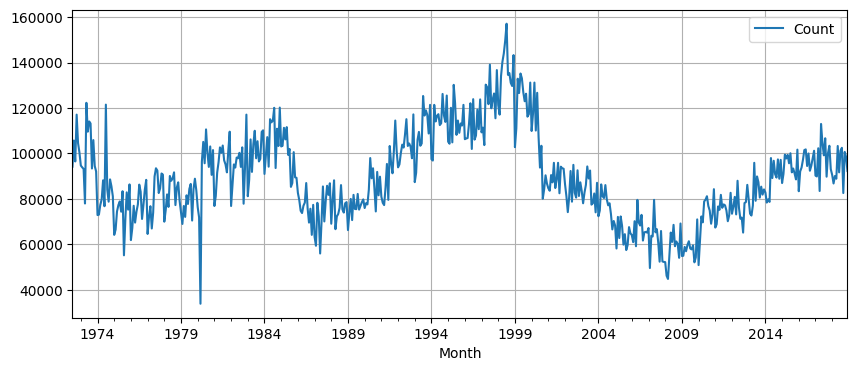

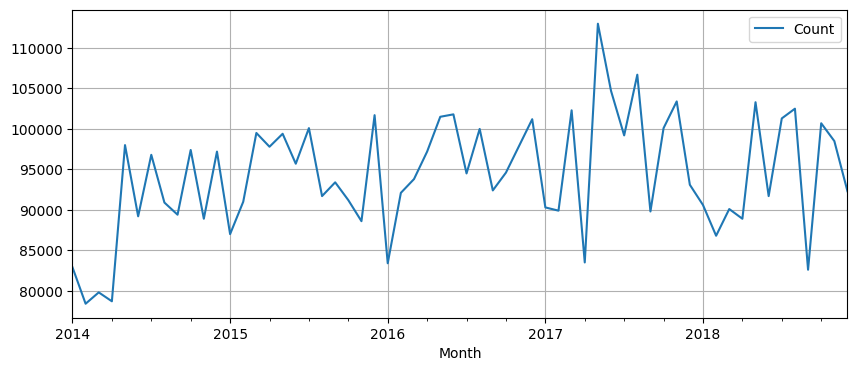

In [3]:
df.plot(x="Month", y="Count", figsize=(10, 4), grid=2)

dfr.plot(x="Month", y="Count", figsize=(10, 4), grid=2)

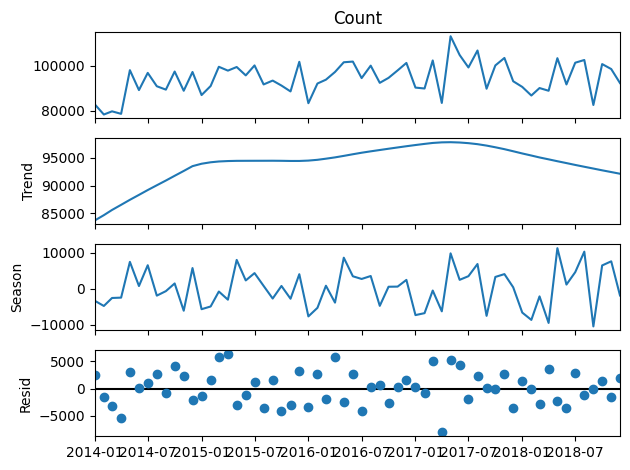

In [27]:
stl = STL(
    dfr.set_index("Month")["Count"],
    period=12,
)

stl = stl.fit()

stl.plot();

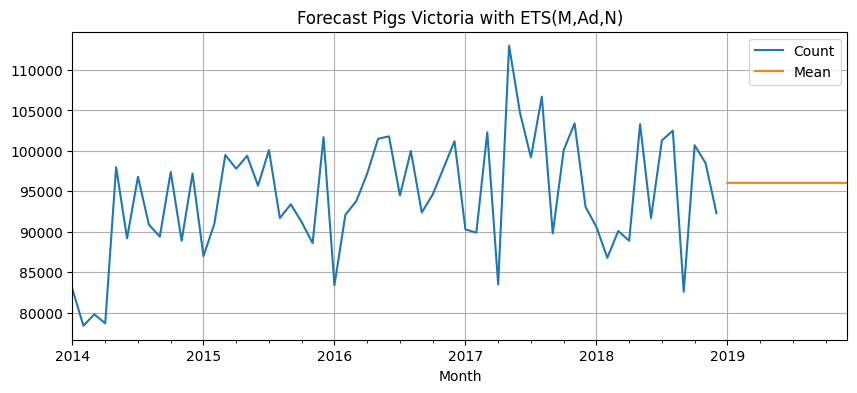

In [63]:
aets = AutoETS(season_length=12)

aets.fit(dfr["Count"].to_numpy())

forecast = pd.DataFrame(
    pd.date_range(
        start=dfr.Month.max(),
        end=dfr.Month.max() + pd.offsets.DateOffset(years=1),
        freq="MS"
    )[1:]
)

forecast.columns = ["Month"]
forecast["Mean"] = aets.predict(h=12)["mean"]

ax=dfr.plot(x="Month", y="Count", figsize=(10, 4), grid=2)

forecast.plot(x="Month", y="Mean", ax=ax, grid=2, title=f"Forecast Pigs Victoria with {aets.model_['method']}");


In [75]:
ets = ETSModel(
    dfr.set_index("Month")["Count"],
    error="add",
    trend="add",
    seasonal="add",
    
    damped_trend=False,
    seasonal_periods=12,    
    initial_level=None,
    initial_trend=None,
    initial_seasonal=None,
    freq="MS",
    missing="none",
    initialization_method="estimated",
)

ets = ets.fit()

ets.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.03159D+01    |proj g|=  8.11524D-01

At iterate    1    f=  1.01953D+01    |proj g|=  8.25677D-01

At iterate    2    f=  1.01917D+01    |proj g|=  1.49138D-01

At iterate    3    f=  1.01885D+01    |proj g|=  1.38891D-01

At iterate    4    f=  1.01872D+01    |proj g|=  1.10209D-01

At iterate    5    f=  1.01867D+01    |proj g|=  4.29079D-02

At iterate    6    f=  1.01831D+01    |proj g|=  8.24492D-02

At iterate    7    f=  1.01821D+01    |proj g|=  6.70568D-02

At iterate    8    f=  1.01820D+01    |proj g|=  6.50369D-02

At iterate    9    f=  1.01815D+01    |proj g|=  1.59128D-02

At iterate   10    f=  1.01813D+01    |proj g|=  1.21119D-02

At iterate   11    f=  1.01812D+01    |proj g|=  3.89822D-03

At iterate   12    f=  1.01812D+01    |proj g|=  1.35536D-04

At iterate   13    f=  1.0

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 ETS Results                                  
==============================================================================
Dep. Variable:                  Count   No. Observations:                   60
Model:                       ETS(AAA)   Log Likelihood                -610.875
Date:                Tue, 19 Dec 2023   AIC                           1257.750
Time:                        16:17:00   BIC                           1295.448
Sample:                    01-01-2014   HQIC                          1272.495
                         - 12-01-2018   Scale                     40817271.595
Covariance Type:               approx                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.1781      0.168      1.061      0.289      -0.151       0.507
smoothing_trend         0.0103      0.039      0.263      0.792      -0.067       0.087
smoothing_seasonal      0.4141        nan        nan        nan         nan         nan
initial_level        8.935e+04   5279.743     16.924      0.000     7.9e+04    9.97e+04
initial_trend         643.8637   2347.119      0.274      0.784   -3956.405    5244.132
initial_seasonal.0  -1.055e+04        nan        nan        nan         nan         nan
initial_seasonal.1  -8590.6250   2840.333     -3.025      0.002   -1.42e+04   -3023.675
initial_seasonal.2  -2165.6250   4675.776     -0.463      0.643   -1.13e+04    6998.728
initial_seasonal.3  -6704.1667   4723.354     -1.419      0.156    -1.6e+04    2553.438
initial_seasonal.4   5611.4583   4600.295      1.220      0.223   -3404.954    1.46e+04
initial_seasonal.5   -262.5000   4795.031     -0.055      0.956   -9660.588    9135.588
initial_seasonal.6    168.7500   4675.751      0.036      0.971   -8995.553    9333.053
initial_seasonal.7   -323.9583   3259.106     -0.099      0.921   -6711.689    6063.772
initial_seasonal.8  -6593.7500   4688.986     -1.406      0.160   -1.58e+04    2596.494
initial_seasonal.9  -2232.2917   4649.951     -0.480      0.631   -1.13e+04    6881.445
initial_seasonal.10 -3518.7500   3194.730     -1.101      0.271   -9780.306    2742.806
initial_seasonal.11          0        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (Q):                       19.99   Jarque-Bera (JB):                 1.38
Prob(Q):                              0.07   Prob(JB):                         0.50
Heteroskedasticity (H):               0.80   Skew:                             0.01
Prob(H) (two-sided):                  0.62   Kurtosis:                         2.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
[2] Covariance matrix is singular or near-singular, with condition number 5.22e+16. Standard errors may be unstable.
"""

In [87]:
r = ets.get_prediction(start=forecast.Month.min(), end=forecast.Month.max())
r = r.summary_frame(alpha=0.05)

r

,mean,pi_lower,pi_upper
2019-01-01,87543.131407,75021.235864,100065.026951
2019-02-01,87286.756065,74544.387668,100029.124461
2019-03-01,93383.207535,80399.932516,106366.482553
2019-04-01,88699.285996,75454.521929,101944.050064
2019-05-01,104353.212255,90826.333053,117880.091456
2019-06-01,96401.713577,82572.145218,110231.281936
2019-07-01,99003.971692,84851.277637,113156.665748
2019-08-01,101143.437493,86647.393253,115639.481733
2019-09-01,86509.005963,71649.662662,101368.349265
2019-10-01,98114.880471,82872.617618,113357.143325


In [96]:
r.reset_index(inplace=True)

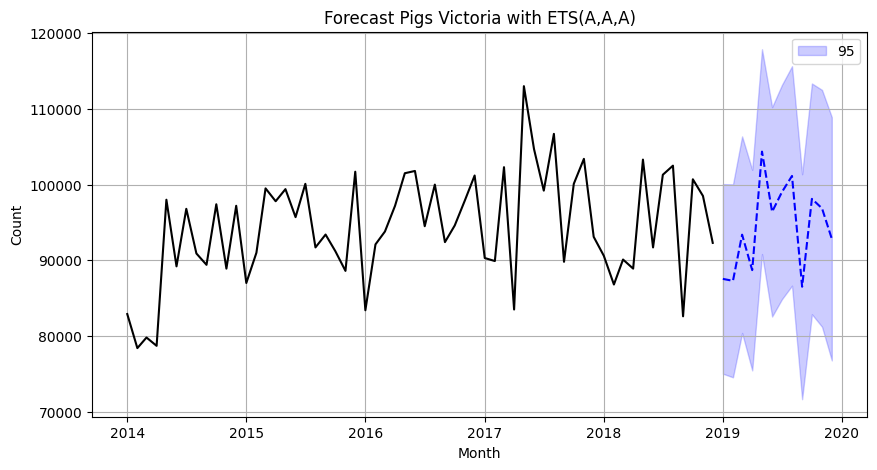

In [98]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(dfr, x="Month", y="Count", ax=ax, color="k")
sns.lineplot(r.reset_index(), x="index", y="mean", ax=ax, color="b", linestyle="--")

ax.fill_between(
    x=r["index"],
    y1=r["pi_lower"].astype(int),
    y2=r["pi_upper"].astype(int),
    color="b",
    label="95",
    alpha=0.2,
)

ax.set_title("Forecast Pigs Victoria with ETS(A,A,A)")
ax.grid(2);
ax.legend();

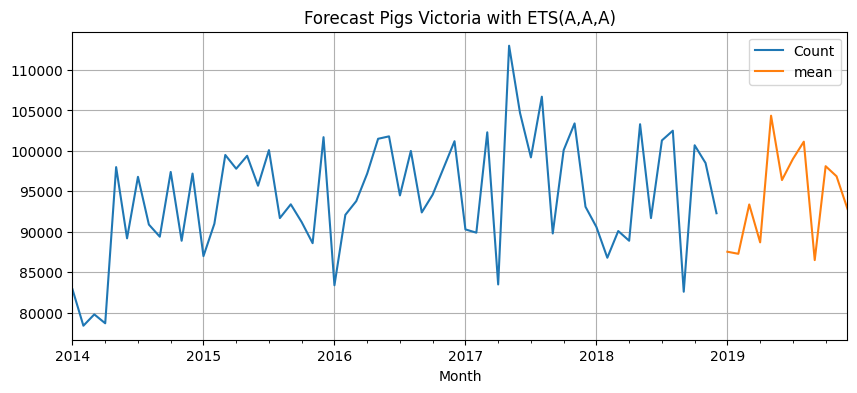

In [86]:
ax=dfr.plot(x="Month", y="Count", figsize=(10, 4), grid=2)

r.plot(y="mean", ax=ax, grid=2, title=f"Forecast Pigs Victoria with ETS(A,A,A)");

#### 2. Write your own function to implement simple exponential smoothing.

In [3]:
dfr.tail()

,Month,Animal,State,Count
55,2018-08-01,Pigs,Victoria,102500.0
56,2018-09-01,Pigs,Victoria,82600.0
57,2018-10-01,Pigs,Victoria,100700.0
58,2018-11-01,Pigs,Victoria,98500.0
59,2018-12-01,Pigs,Victoria,92300.0


$y_{t + 1} = \alpha * y_t + \alpha * (1 - \alpha ) * y_{t - 1} + \alpha * (1 - \alpha)^2 * y_{t - 2}$

In [5]:
def simple_exp_smoothing(
    y: np.array,
    a: float,
    l0: int = 0
):

    if a > 1 or a < 0:
        raise ValueError(f"alpha >= 0 or alpha <= 1, alpha is: {a}")

    # Index 0 and 1
    z1 = a * y[y.shape[0] - 1]
    z2 = a * (1 - a) * y[y.shape[0] - 2]

    z = z1 + z2

    for i in range(2, y.shape[0]):
        z += a * (1 - a) ** i * y[i]

    return z


for alpha in [0.1, 0.5, 1]:
    forecast = simple_exp_smoothing(
        y=dfr["Count"].to_numpy(),
        a=alpha
    )

    print(f"Alpha: {alpha}, Forecast: {forecast}")

Alpha: 0.1, Forecast: 91825.92379979808
Alpha: 0.5, Forecast: 91595.3864863107
Alpha: 1, Forecast: 92300.0


$\hat{y}_{T+1|T} =  \sum_{j=0}^{T-1} \alpha(1-\alpha)^j y_{T-j} + (1-\alpha)^T \ell_{0}$

In [37]:
def simple_exp_smoothing(
    y: np.array,
    a: float,
    l0: int = 1
):
    T = len(y)
    z = l0
    z = (1 - a) ** T * l0

    for j in range(0, y.shape[0] - 1):
        z += a * (1 - a) ** j * y[T - j - 1]

    return z

y = dfr["Count"].to_numpy()

for alpha in [0.1, 0.5, 1.0]:
    forecast = simple_exp_smoothing(y, alpha, 0)

    print(f"Alpha: {alpha}, Forecast: {forecast}")

Alpha: 0.1, Forecast: 95392.78244008528
Alpha: 0.5, Forecast: 94780.66938749659
Alpha: 1.0, Forecast: 92300.0


In [7]:
for alpha in [0.1, 0.5, 1.0]:
    s = SimpleExponentialSmoothing(alpha=alpha).fit(dfr["Count"].to_numpy())

    print(f"Alpha: {alpha}, Forecast: {s.predict(1)['mean'][0]}")

Alpha: 0.1, Forecast: 95558.3046875
Alpha: 0.5, Forecast: 94780.671875
Alpha: 1.0, Forecast: 92300.0


In [8]:
s.model_

{'mean': array([92300.], dtype=float32),
 'fitted': array([    nan,  82900.,  78400.,  79800.,  78700.,  98000.,  89200.,
         96800.,  90900.,  89400.,  97400.,  88900.,  97200.,  87000.,
         91000.,  99500.,  97800.,  99400.,  95700., 100100.,  91700.,
         93400.,  91200.,  88600., 101700.,  83400.,  92100.,  93800.,
         97200., 101500., 101800.,  94500., 100000.,  92400.,  94600.,
         97900., 101200.,  90300.,  89900., 102300.,  83500., 113000.,
        104700.,  99200., 106700.,  89800., 100100., 103400.,  93100.,
         90600.,  86800.,  90100.,  88900., 103300.,  91700., 101300.,
        102500.,  82600., 100700.,  98500.], dtype=float32)}

In [47]:
s = SimpleExponentialSmoothing(alpha=0.9).fit(dfr["Count"].to_numpy())

s.model_

{'mean': array([92925.87], dtype=float32),
 'fitted': array([       nan,  82900.   ,  78850.   ,  79705.   ,  78800.5  ,
         96080.05 ,  89888.01 ,  96108.8  ,  91420.88 ,  89602.086,
         96620.21 ,  89672.02 ,  96447.2  ,  87944.72 ,  90694.47 ,
         98619.445,  97881.945,  99248.195,  96054.82 ,  99695.484,
         92499.55 ,  93309.95 ,  91410.99 ,  88881.1  , 100418.11 ,
         85101.81 ,  91400.18 ,  93560.016,  96836.   , 101033.6  ,
        101723.36 ,  95222.336,  99522.234,  93112.23 ,  94451.22 ,
         97555.125, 100835.516,  91353.555,  90045.35 , 101074.54 ,
         85257.45 , 110225.74 , 105252.58 ,  99805.26 , 106010.52 ,
         91421.055,  99232.1  , 102983.21 ,  94088.32 ,  90948.836,
         87214.88 ,  89811.49 ,  88991.15 , 101869.12 ,  92716.914,
        100441.69 , 102294.17 ,  84569.414,  99086.945,  98558.695],
       dtype=float32)}

#### 3. Modify your function from the previous exercise to return the sum of squared errors rather than the forecast of the next observation. 

In [6]:
y = dfr["Count"].to_numpy()

\begin{align*}
  \text{Forecast equation}  && \hat{y}_{t+h|t} & = \ell_{t}\\
  \text{Smoothing equation} && \ell_{t}        & = \alpha y_{t} + (1 - \alpha)\ell_{t-1},
\end{align*}

In [5]:
s = SimpleExponentialSmoothing(alpha=0.5).fit(dfr["Count"].to_numpy())

s.model_

{'mean': array([94780.67], dtype=float32),
 'fitted': array([       nan,  82900.   ,  80650.   ,  80225.   ,  79462.5  ,
         88731.25 ,  88965.625,  92882.81 ,  91891.41 ,  90645.7  ,
         94022.85 ,  91461.42 ,  94330.71 ,  90665.36 ,  90832.68 ,
         95166.336,  96483.17 ,  97941.586,  96820.79 ,  98460.4  ,
         95080.195,  94240.1  ,  92720.05 ,  90660.02 ,  96180.016,
         89790.01 ,  90945.   ,  92372.5  ,  94786.25 ,  98143.125,
         99971.56 ,  97235.78 ,  98617.89 ,  95508.945,  95054.48 ,
         96477.234,  98838.62 ,  94569.31 ,  92234.66 ,  97267.33 ,
         90383.664, 101691.83 , 103195.914, 101197.96 , 103948.98 ,
         96874.49 ,  98487.24 , 100943.625,  97021.81 ,  93810.91 ,
         90305.45 ,  90202.73 ,  89551.36 ,  96425.68 ,  94062.84 ,
         97681.42 , 100090.71 ,  91345.35 ,  96022.68 ,  97261.336],
       dtype=float32)}

In [6]:
def simple_exp_smoothing(
    y: np.array,
    a: float,
    l0: int = 1
):
    T = len(y)
    
    lt = (1 - a) ** T * l0

    fitted = np.zeros(T)
    residuals = np.zeros(T)

    for j in range(1, y.shape[0]):

        # Smoothing equation
        lt = a * y[j - 1] + (1 - a) * lt

        # Using last smoothing for forecast y[j]
        fitted[j] = lt
        residuals[j] = y[j] - lt

    sse = np.sum(residuals ** 2)

    return lt, fitted, residuals, sse

alpha = 0.5

forecast, fitted, residuals, sse = simple_exp_smoothing(y, 0.5, 1)

sse, forecast, fitted, residuals

(5381388591.703409,
 97261.3387749932,
 array([     0.        ,  41450.        ,  59925.        ,  69862.5       ,
         74281.25      ,  86140.625     ,  87670.3125    ,  92235.15625   ,
         91567.578125  ,  90483.7890625 ,  93941.89453125,  91420.94726562,
         94310.47363281,  90655.23681641,  90827.6184082 ,  95163.8092041 ,
         96481.90460205,  97940.95230103,  96820.47615051,  98460.23807526,
         95080.11903763,  94240.05951881,  92720.02975941,  90660.0148797 ,
         96180.00743985,  89790.00371993,  90945.00185996,  92372.50092998,
         94786.25046499,  98143.1252325 ,  99971.56261625,  97235.78130812,
         98617.89065406,  95508.94532703,  95054.47266352,  96477.23633176,
         98838.61816588,  94569.30908294,  92234.65454147,  97267.32727073,
         90383.66363537, 101691.83181768, 103195.91590884, 101197.95795442,
        103948.97897721,  96874.48948861,  98487.2447443 , 100943.62237215,
         97021.81118608,  93810.90559304,  90305.

#### 4. Combine your previous two functions to produce a function that both finds the optimal values of α and ℓo 

Tree of Parzen from a medium post for fine tuning alpha and l0.

In [51]:
class SimpleExponentialSmoothing():
    def __init__(self):
        ...

    def __str__(self):
        return "Simple Exponential Smoothing with Fit, Forecast and Hyperparameter tuning with TPE."

    def fit(
        self,
        y: np.array,
        alpha: float,
        l0: float
    ):
        T = len(y)
        lt = (1 - alpha) ** T * l0

        self.fitted = np.zeros(T)
        self.residuals = np.zeros(T)

        for j in range(1, y.shape[0]):
            
            # Smoothing equation
            lt = alpha * y[j - 1] + (1 - alpha) * lt

            # Using last smoothing for forecast y[j]
            self.fitted[j] = lt
            self.residuals[j] = y[j] - lt

        self.sse = np.sum(self.residuals ** 2)
        self.y_t1 = lt

        return self
    
    def forecast(
        self, h:
        int = 1
    ):
        return np.array([self.y_t1] * h)

    def fit_start_sample_priors(
        self,
        y: np.array,
        n_start_samples: int = 100
    ):
        prior_alphas = np.array([1 if k > 1 else k for k in np.abs(np.random.normal(0, 1, n_start_samples))])
        prior_l0 = np.array([1 if k > 1 else k for k in np.abs(np.random.normal(0, 1, n_start_samples))])

        sses = np.array([self.fit(y, a, l).sse for a, l in zip(prior_alphas, prior_l0)])

        return np.vstack((prior_alphas, prior_l0, sses)).T
    
    def segment_distributions(
        self,
        sample_trials,
        gamma = 0.2,
        kernel = "gaussian",
        bandwidth = 0.5
    ): 
        c = np.quantile(sample_trials[:, -1], gamma)

        lx = sample_trials[sample_trials[:, -1] < c]
        gx = sample_trials[sample_trials[:, -1] >= c]

        lkde = KernelDensity(kernel=kernel, bandwidth=bandwidth)
        gkde = KernelDensity(kernel=kernel, bandwidth=bandwidth)

        lkde = lkde.fit(lx[:, :-1])
        gkde = gkde.fit(gx[:, :-1])

        return lkde, gkde

    def choose_next_hyperparams(
        self,
        lkde: KernelDensity,
        gkde: KernelDensity,
        good_n_samples: int = 1000
    ):        
        samples = lkde.sample(good_n_samples)

        l_score = lkde.score_samples(samples)
        g_score = gkde.score_samples(samples)

        # Maximizes g(x) / l(x) 
        next_hyperparams = samples[np.argmax(g_score / l_score)]

        return next_hyperparams
    
    def tuning_tpe(
        self,
        y,
        prior_n_samples = 100,
        good_n_samples = 100,
        gamma = 0.6,
        n_trials = 100,
        bandwidth = 0.5,
        kernel = "gaussian"
    ):

        self.priors = self.fit_start_sample_priors(y, prior_n_samples)

        for i in range(0, n_trials):
            lkde, gkde = self.segment_distributions(self.priors, gamma=gamma, kernel=kernel, bandwidth=bandwidth)

            hps = self.choose_next_hyperparams(lkde, gkde, good_n_samples)

            hps = np.append(hps, self.fit(y, hps[0], hps[1]).sse)

            self.priors = np.concatenate((self.priors, hps.reshape(1, 3)), axis=0)

        self.alpha, self.lo, _ = self.priors[self.priors[:, -1] == self.priors[:, -1].min()][0]

        self.fit(y, self.alpha, self.lo)

        return self
    

In [52]:
ses = SimpleExponentialSmoothing()
print(ses)
ses = ses.tuning_tpe(
    y=y,
    prior_n_samples=10,
    good_n_samples=100,
    gamma=0.5,
    n_trials=100
)

Simple Exponential Smoothing with Fit, Forecast and Hyperparameter tuning with TPE.


In [53]:
ses.forecast(h=10)

array([98163.76992408, 98163.76992408, 98163.76992408, 98163.76992408,
       98163.76992408, 98163.76992408, 98163.76992408, 98163.76992408,
       98163.76992408, 98163.76992408])

In [54]:
pd.DataFrame(ses.priors)

,0,1,2
0,1.000000,1.000000,5.268220e+09
1,0.284108,0.505673,1.058362e+10
2,1.000000,0.701037,5.268220e+09
3,1.000000,0.973468,5.268220e+09
4,0.704623,0.120769,4.332230e+09
...,...,...,...
105,0.689780,-0.214596,4.349750e+09
106,0.752520,-0.278737,4.322902e+09
107,0.812398,-0.350530,4.404494e+09
108,0.765198,-0.299623,4.331841e+09


In [78]:
A, L0 = ses.priors[10:, 0], ses.priors[10:, 1]

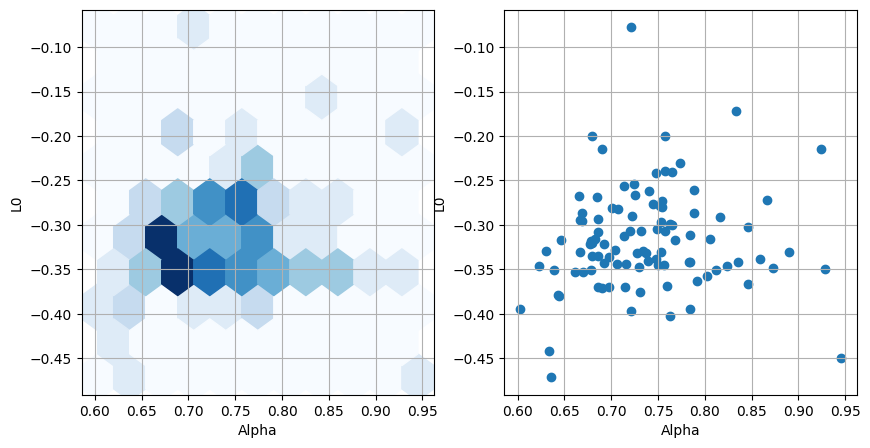

In [108]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].hexbin(A, L0, gridsize=10, cmap="Blues")
ax[1].scatter(A, L0)
for axi in ax:
    axi.set_xlabel("Alpha")
    axi.set_ylabel("L0")
    axi.grid(2);

#### 5. Data set global_economy contains the annual Exports from many countries. Select one country to analyse.

In [253]:
df = pd.read_csv("../data/global_economy.csv", index_col=[0])

df = df[df.Country == "Brazil"].reset_index(drop=True)

df["Year"] = pd.to_datetime(df["Year"], format="%Y")

df = df[["Year", "Exports"]]

##### a) Plot the series and discuss the main features.

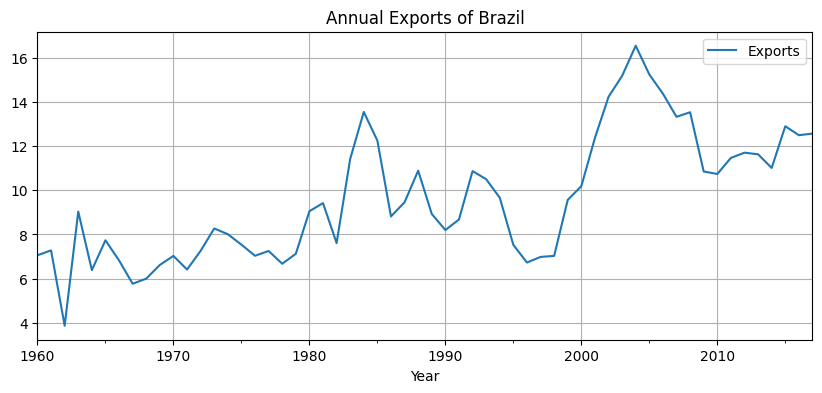

In [254]:
df.plot(x="Year", figsize=(10, 4), grid=2, title="Annual Exports of Brazil");

- Trend looks like increassing.
- No seasonality.
- Looks like very noisy.
- A down in 90's to 20's, maybe results of brazil in world wars.


##### b) Use an ETS(A,N,N) model to forecast the series, and plot the forecasts.

In [275]:
ets = ETSModel(
    df.set_index("Year")["Exports"],
    error="add",
    trend=None,
    seasonal=None,
    #freq="Y"
).fit(disp=0)

ets.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 ETS Results                                  
==============================================================================
Dep. Variable:                Exports   No. Observations:                   58
Model:                       ETS(ANN)   Log Likelihood                -107.817
Date:                Wed, 27 Dec 2023   AIC                            221.634
Time:                        16:07:35   BIC                            227.815
Sample:                    01-01-1960   HQIC                           224.042
                         - 01-01-2017   Scale                            2.411
Covariance Type:               approx                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
smoothing_level     0.8218      0.135      6.093      0.000       0.557       1.086
initial_level       7.0168      1.530      4.587      0.000       4.019      10.015
===================================================================================
Ljung-Box (Q):                        0.07   Jarque-Bera (JB):                 1.33
Prob(Q):                              0.96   Prob(JB):                         0.51
Heteroskedasticity (H):               0.86   Skew:                             0.23
Prob(H) (two-sided):                  0.75   Kurtosis:                         3.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

##### c) Compute RMSE for training dataset

In [261]:
np.sqrt(ets.mse)

1.552669361392315

##### d) Compare the results to those from an ETS(A,A,N) model. (Remember that the trended model is using one more parameter than the simpler model.) Discuss the merits of the two forecasting methods for this data set.

In [276]:
ets2 = ETSModel(
    df.set_index("Year")["Exports"],
    error="add",
    trend="add",
    seasonal=None,
    #freq="Y"
).fit(disp=0)

ets2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 ETS Results                                  
==============================================================================
Dep. Variable:                Exports   No. Observations:                   58
Model:                       ETS(AAN)   Log Likelihood                -107.651
Date:                Wed, 27 Dec 2023   AIC                            225.302
Time:                        16:07:41   BIC                            235.604
Sample:                    01-01-1960   HQIC                           229.315
                         - 01-01-2017   Scale                            2.397
Covariance Type:               approx                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
smoothing_level     0.8136      0.112      7.272      0.000       0.594       1.033
smoothing_trend  8.136e-05        nan        nan        nan         nan         nan
initial_level       6.8915      1.538      4.482      0.000       3.878       9.905
initial_trend       0.0981      0.168      0.584      0.559      -0.231       0.427
===================================================================================
Ljung-Box (Q):                        0.09   Jarque-Bera (JB):                 1.21
Prob(Q):                              0.96   Prob(JB):                         0.55
Heteroskedasticity (H):               0.88   Skew:                             0.22
Prob(H) (two-sided):                  0.78   Kurtosis:                         3.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

##### e) Compare the forecasts from both methods. Which do you think is best?

I select ETS(A,A,N) because exports of brazil looks like increasing.

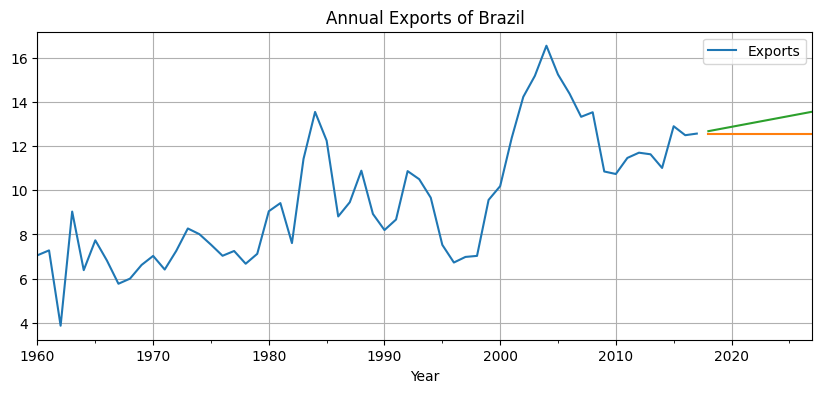

In [273]:
ax = df.plot(x="Year", figsize=(10, 4), title="Annual Exports of Brazil")
ax = ets.forecast(10).plot(ax=ax)
ax = ets2.forecast(10).plot(ax=ax, grid=2)

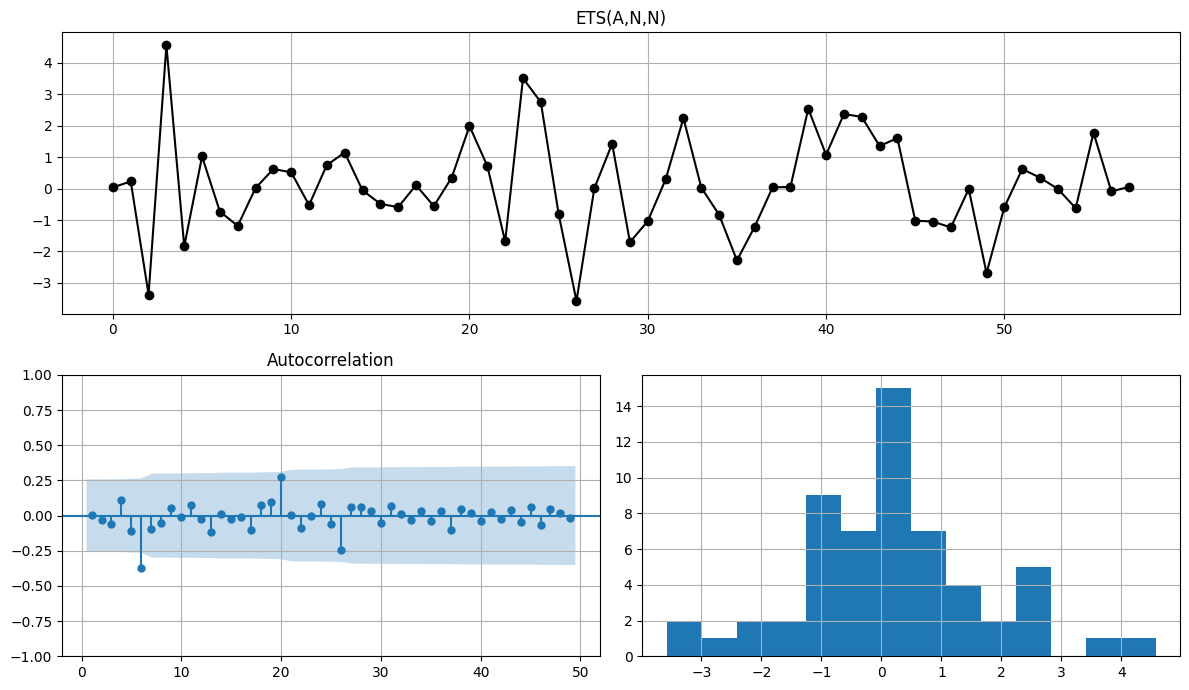

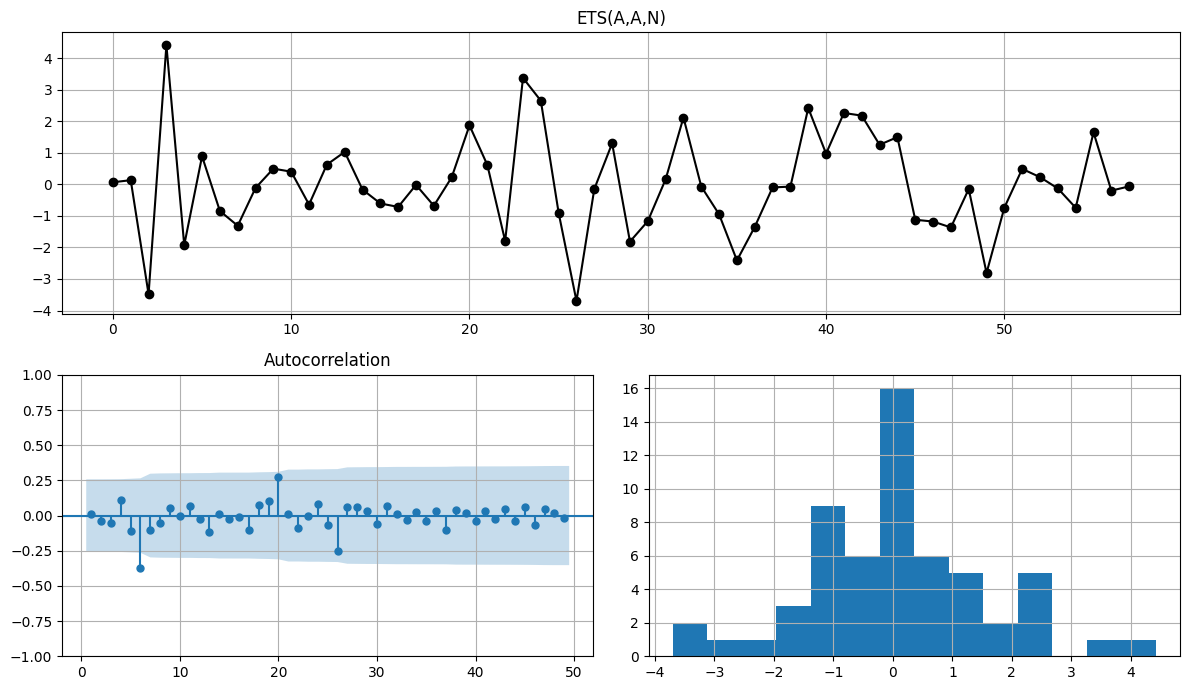

In [278]:
df["resid"] = ets.resid.values

plot_ts_resid(df, "Month", y="resid", title="ETS(A,N,N)", n_lags=range(1, 50))

df["resid"] = ets2.resid.values

plot_ts_resid(df, "Month", y="resid", title="ETS(A,A,N)", n_lags=range(1, 50))

##### f) Calculate a 95% prediction interval for the first forecast for each model, using the RMSE values and assuming normal errors. Compare your intervals with those produced using R.

I need to use RMSE for compute forecast interval ?

#### 6. Forecast the Chinese GDP from the global_economy data set using an ETS model.

Wtf is this xD

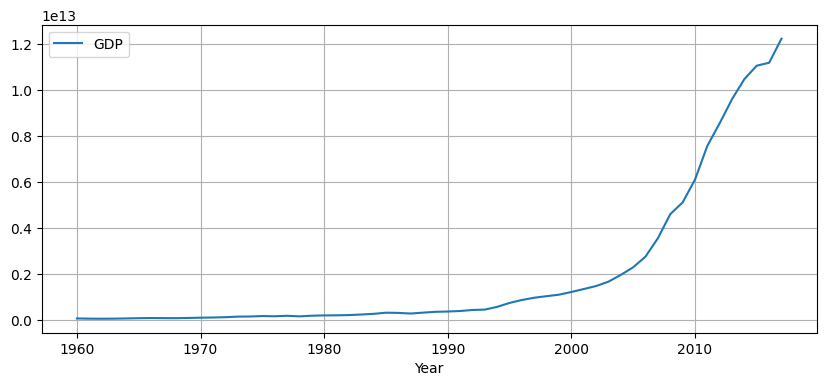

In [98]:
df = pd.read_csv("../data/global_economy.csv")

df = df.loc[df.Country == "China", ["Year", "GDP"]].reset_index(drop=True)

df.plot(x="Year", figsize=(10, 4), grid=2);

#### 7. Find an ETS model for the Gas data from aus_production and forecast the next few years.

Why is multiplicative seasonality necessary here? Experiment with making the trend damped. Does it improve the forecasts?

I need a multiplicative if i use dataset with heteroskedasticity, with a filter dataset looks like very more simple for forecast.

In [18]:
df = pd.read_csv("../data/aus_production.csv", index_col=[0])
df['Quarter'] = df.Quarter.apply(lambda x: x.replace(' ', '-'))
df['Quarter'] = pd.PeriodIndex(df.Quarter, freq='Q').to_timestamp()

df = df[["Quarter", "Gas"]].reset_index(drop=True)
df.columns = ["quarter", "gas"]

# I will filter the dataset to remove noisy data greater than 90's

df = df[df["quarter"] >= "1990-01-01"].reset_index(drop=True)

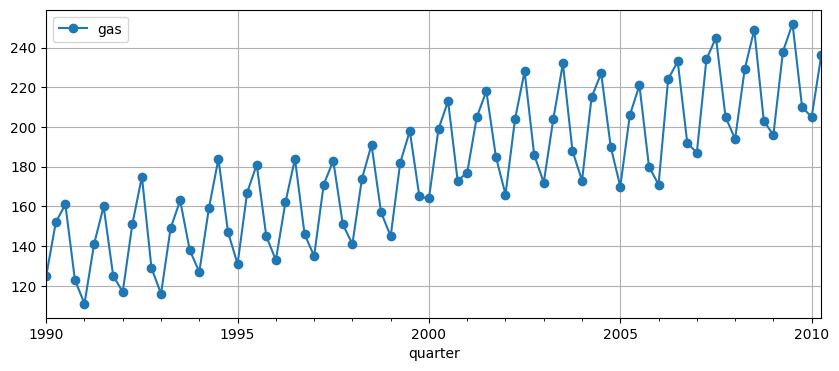

In [19]:
df.plot(x="quarter", grid=2, figsize=(10, 4), marker="o");

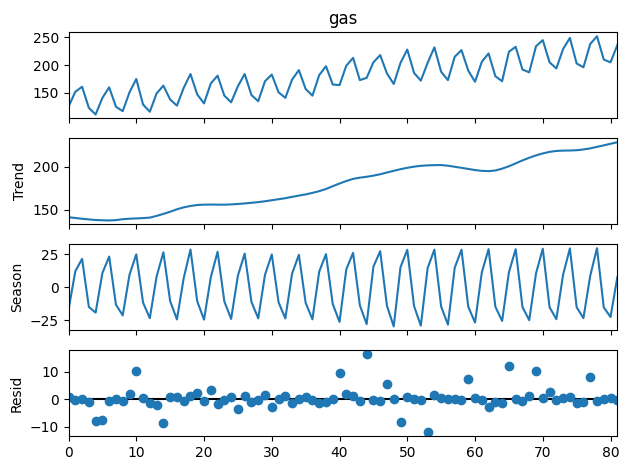

In [25]:
# ETS(A, A, A)
stl = STL(df["gas"], period=4, robust=True).fit().plot()

In [50]:
ets = AutoETS(
    season_length=4
).fit(df["gas"].to_numpy())

ets.model_

{'loglik': 333.54375017736635,
 'aic': -661.0875003547327,
 'bic': -653.86734261294,
 'aicc': -660.7798080470404,
 'mse': 525.9820711203591,
 'amse': 512.4362096578394,
 'fit': results(x=array([  0.16753638, 140.16560084]), fn=876.5696252904162, nit=17, simplex=array([[  0.16753638, 140.16560084],
        [  0.16754445, 139.980504  ],
        [  0.16790108, 140.06828121]])),
 'residuals': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'components': 'MNNN',
 'm': 1,
 'nstate': 1,
 'fitted': array([125., 152., 161., 123., 111., 141., 160., 125., 117., 151., 175.,
        129., 116., 149., 163., 138., 127., 159., 184., 147., 131., 167.,
        181., 145., 133., 162., 184., 146., 135., 171., 183., 151., 141.,
        174., 191., 157., 145., 182., 198., 165., 1

In [49]:
ets2 = ETSModel(
    df.set_index("quarter")["gas"],
    error="add",
    trend="add",
    seasonal="add",
    freq="QS-JAN"
).fit(disp=0)

ets2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 ETS Results                                  
==============================================================================
Dep. Variable:                    gas   No. Observations:                   82
Model:                       ETS(AAA)   Log Likelihood                -252.567
Date:                Wed, 27 Dec 2023   AIC                            525.134
Time:                        14:55:06   BIC                            549.201
Sample:                    01-01-1990   HQIC                           534.797
                         - 04-01-2010   Scale                           27.724
Covariance Type:               approx                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
smoothing_level        0.5754      0.103      5.560      0.000       0.373       0.778
smoothing_trend     5.754e-05        nan        nan        nan         nan         nan
smoothing_seasonal     0.1091      0.077      1.415      0.157      -0.042       0.260
initial_level        120.7880   1.25e+05      0.001      0.999   -2.45e+05    2.45e+05
initial_trend          1.0048      0.358      2.810      0.005       0.304       1.706
initial_seasonal.0    10.1438   1.25e+05   8.13e-05      1.000   -2.45e+05    2.45e+05
initial_seasonal.1    47.5914   1.25e+05      0.000      1.000   -2.45e+05    2.45e+05
initial_seasonal.2    32.0833   1.25e+05      0.000      1.000   -2.45e+05    2.45e+05
initial_seasonal.3          0   1.25e+05          0      1.000   -2.45e+05    2.45e+05
===================================================================================
Ljung-Box (Q):                        6.56   Jarque-Bera (JB):                 9.50
Prob(Q):                              0.59   Prob(JB):                         0.01
Heteroskedasticity (H):               1.28   Skew:                             0.74
Prob(H) (two-sided):                  0.52   Kurtosis:                         3.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

In [59]:
forecast = pd.DataFrame(
    pd.date_range(
        start=df.quarter.max(),
        end=df.quarter.max() + pd.DateOffset(years=5),
        freq="Q-JAN"    
    ),
).rename(columns={0: "quarter"})

In [68]:
forecast["AutoETS"] = ets.predict(len(forecast))["mean"]
forecast["ETS(A,A,A)"] = ets2.predict(start=forecast.quarter.min(), end=forecast.quarter.max()).values

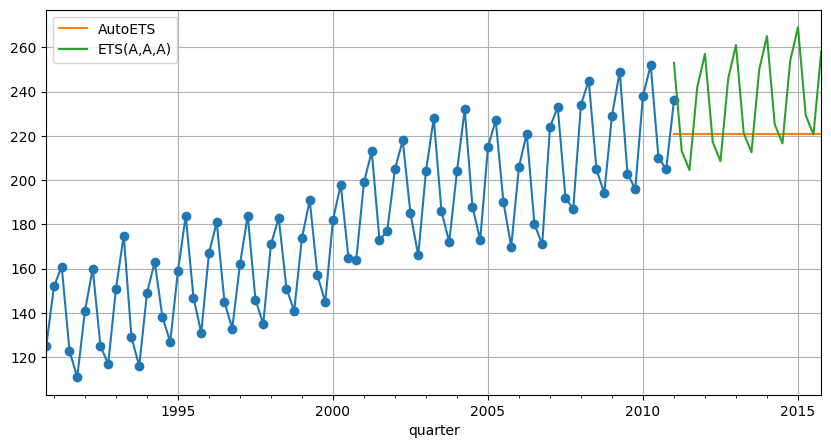

In [88]:
ax = df.set_index("quarter")["gas"].resample("Q-JAN").sum().plot(figsize=(10, 5), marker="o")
forecast.set_index("quarter").resample("Q-JAN").sum().plot(ax=ax, grid=2);

#### 8. Recall your retail time series data (from Exercise 7 in Section 2.10).

In [185]:
np.random.seed(12345678)

df = pd.read_csv("../data/aus_retail.csv", index_col=[0])

df = df[df["Series ID"].isin(df["Series ID"].sample(1).values)]

df["Month"] = pd.to_datetime(df["Month"], format="%Y %b")

df.reset_index(drop=True, inplace=True)

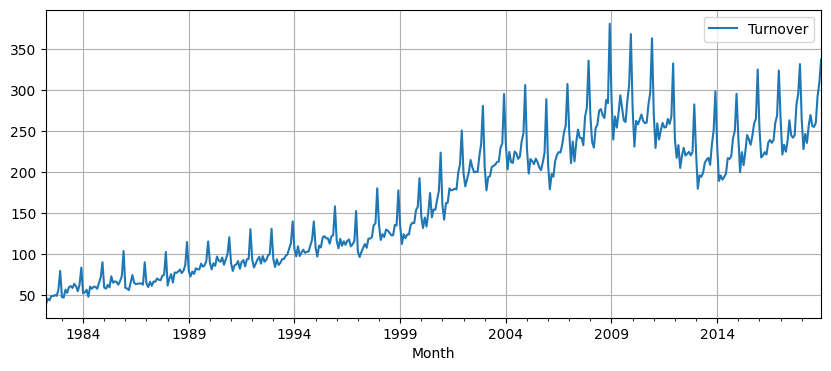

In [193]:
df.plot(x="Month", grid=2, figsize=(10, 4));

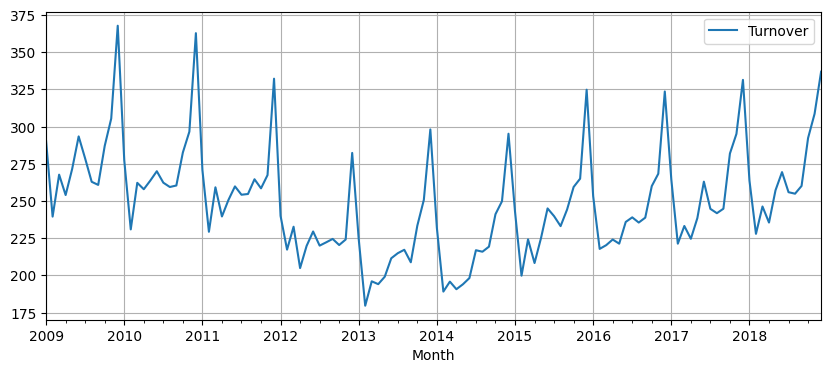

In [198]:
dff = df[df["Month"] >= "2009-01-01"].reset_index(drop=True)

dff.plot(x="Month", grid=2, figsize=(10, 4));

##### a) Why is multiplicative seasonality necessary for this series?

Because have heteroskedasticity on seasonality (value increase as the level increase), or apply a log on sasonality.

But i can use a filter series too to reduce the problems with heteroskedasticity and get most recent years of observations.

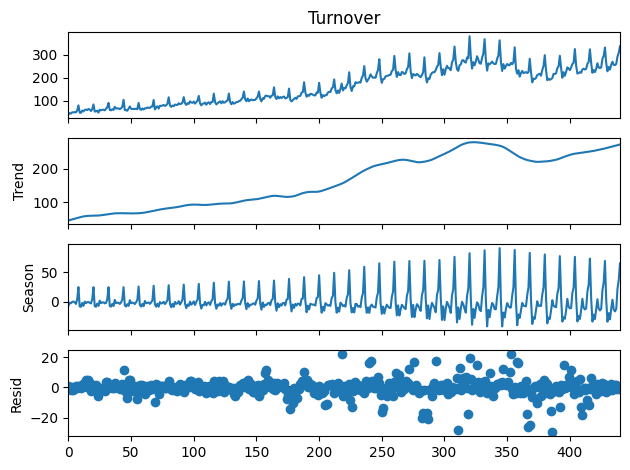

In [189]:
stl = STL(df["Turnover"], period=12, robust=True).fit().plot()

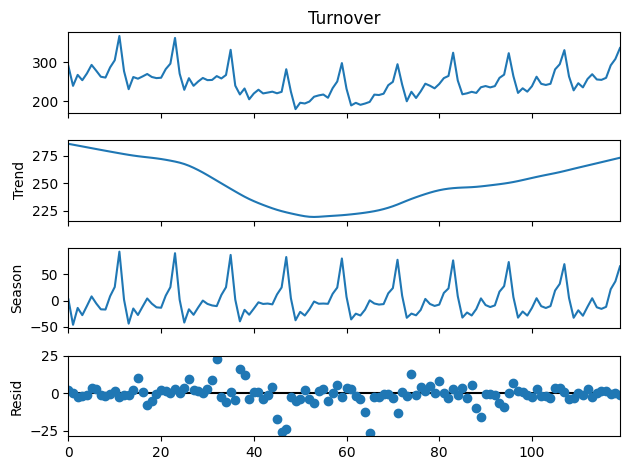

In [199]:
stl = STL(dff["Turnover"], period=12, robust=True).fit().plot()

##### b) Apply Holt-Winters’ multiplicative method to the data. Experiment with making the trend damped.

In [203]:
ets = ETSModel(
    df.set_index("Month")["Turnover"],
    error="mul",
    trend="mul",
    seasonal="mul",
    damped_trend=True,
    freq="MS"
).fit(disp=0)

ets.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 ETS Results                                  
==============================================================================
Dep. Variable:               Turnover   No. Observations:                  441
Model:                      ETS(MMdM)   Log Likelihood               -1450.618
Date:                Wed, 27 Dec 2023   AIC                           2939.236
Time:                        15:44:30   BIC                           3016.928
Sample:                    04-01-1982   HQIC                          2969.883
                         - 12-01-2018   Scale                            0.002
Covariance Type:               approx                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.4560      0.035     13.184      0.000       0.388       0.524
smoothing_trend         0.0091        nan        nan        nan         nan         nan
smoothing_seasonal      0.1656      0.025      6.502      0.000       0.116       0.216
damping_trend           0.9800        nan        nan        nan         nan         nan
initial_level          39.0920    328.153      0.119      0.905    -604.076     682.260
initial_trend           1.0191        nan        nan        nan         nan         nan
initial_seasonal.0      1.0681      8.966      0.119      0.905     -16.505      18.642
initial_seasonal.1      0.9778      8.208      0.119      0.905     -15.110      17.066
initial_seasonal.2      1.0303      8.649      0.119      0.905     -15.921      17.981
initial_seasonal.3      1.5903     13.350      0.119      0.905     -24.575      27.755
initial_seasonal.4      1.1760      9.872      0.119      0.905     -18.173      20.525
initial_seasonal.5      1.0975      9.213      0.119      0.905     -16.959      19.154
initial_seasonal.6      1.0807      9.072      0.119      0.905     -16.700      18.861
initial_seasonal.7      1.1102      9.319      0.119      0.905     -17.155      19.376
initial_seasonal.8      1.1013      9.244      0.119      0.905     -17.018      19.220
initial_seasonal.9      1.0732      9.009      0.119      0.905     -16.584      18.731
initial_seasonal.10     1.1282      9.470      0.119      0.905     -17.433      19.690
initial_seasonal.11     1.0000      8.394      0.119      0.905     -15.452      17.452
===================================================================================
Ljung-Box (Q):                       52.82   Jarque-Bera (JB):                17.68
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.51   Skew:                             0.18
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

In [205]:
ets2 = ETSModel(
    df.set_index("Month")["Turnover"],
    error="mul",
    trend="mul",
    seasonal="mul",
    damped_trend=False,
    freq="MS"
).fit(disp=0)

ets2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 ETS Results                                  
==============================================================================
Dep. Variable:               Turnover   No. Observations:                  441
Model:                       ETS(MMM)   Log Likelihood               -1452.487
Date:                Wed, 27 Dec 2023   AIC                           2940.975
Time:                        15:44:47   BIC                           3014.578
Sample:                    04-01-1982   HQIC                          2970.008
                         - 12-01-2018   Scale                            0.002
Covariance Type:               approx                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.4778      0.038     12.699      0.000       0.404       0.551
smoothing_trend      4.778e-05        nan        nan        nan         nan         nan
smoothing_seasonal      0.1687      0.026      6.440      0.000       0.117       0.220
initial_level          40.0019    200.887      0.199      0.842    -353.730     433.734
initial_trend           1.0043      0.001    938.087      0.000       1.002       1.006
initial_seasonal.0      1.0738      5.392      0.199      0.842      -9.495      11.643
initial_seasonal.1      0.9815      4.929      0.199      0.842      -8.680      10.642
initial_seasonal.2      1.0317      5.181      0.199      0.842      -9.123      11.187
initial_seasonal.3      1.5992      8.031      0.199      0.842     -14.141      17.339
initial_seasonal.4      1.1800      5.926      0.199      0.842     -10.435      12.795
initial_seasonal.5      1.0980      5.514      0.199      0.842      -9.710      11.906
initial_seasonal.6      1.0844      5.446      0.199      0.842      -9.589      11.758
initial_seasonal.7      1.1127      5.588      0.199      0.842      -9.840      12.065
initial_seasonal.8      1.1035      5.542      0.199      0.842      -9.758      11.965
initial_seasonal.9      1.0744      5.396      0.199      0.842      -9.501      11.650
initial_seasonal.10     1.1294      5.672      0.199      0.842      -9.987      12.246
initial_seasonal.11     1.0000      5.022      0.199      0.842      -8.843      10.843
===================================================================================
Ljung-Box (Q):                       54.94   Jarque-Bera (JB):                22.77
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.51   Skew:                             0.28
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

##### c) Compare the RMSE of the one-step forecasts from the two methods. Which do you prefer?


I cannot forecast and compare one step forecast because i do not have the next observation to forecast.

In [212]:
ets_damped_rmse = np.sqrt(mean_squared_error(df["Turnover"], ets.fittedvalues.values))
ets_no_damped_rmse = np.sqrt(mean_squared_error(df["Turnover"], ets2.fittedvalues.values))

ets_damped_rmse, ets_no_damped_rmse

(7.133115015706535, 7.22076284066841)

##### d) Check that the residuals from the best method look like white noise.

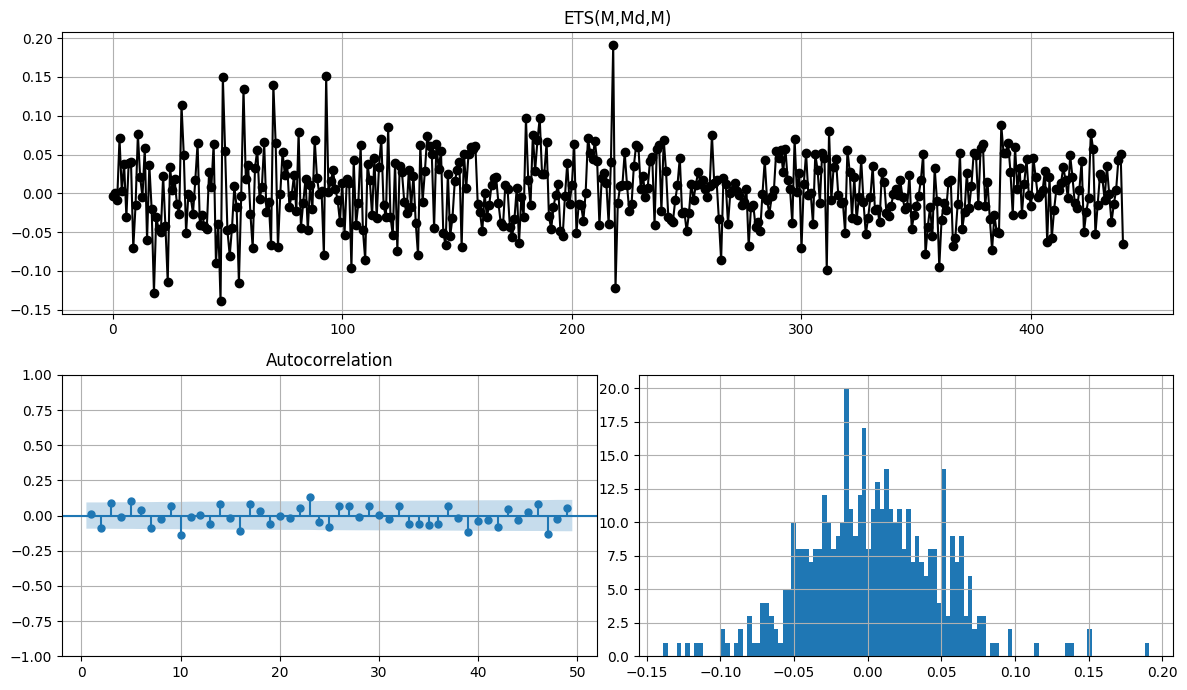

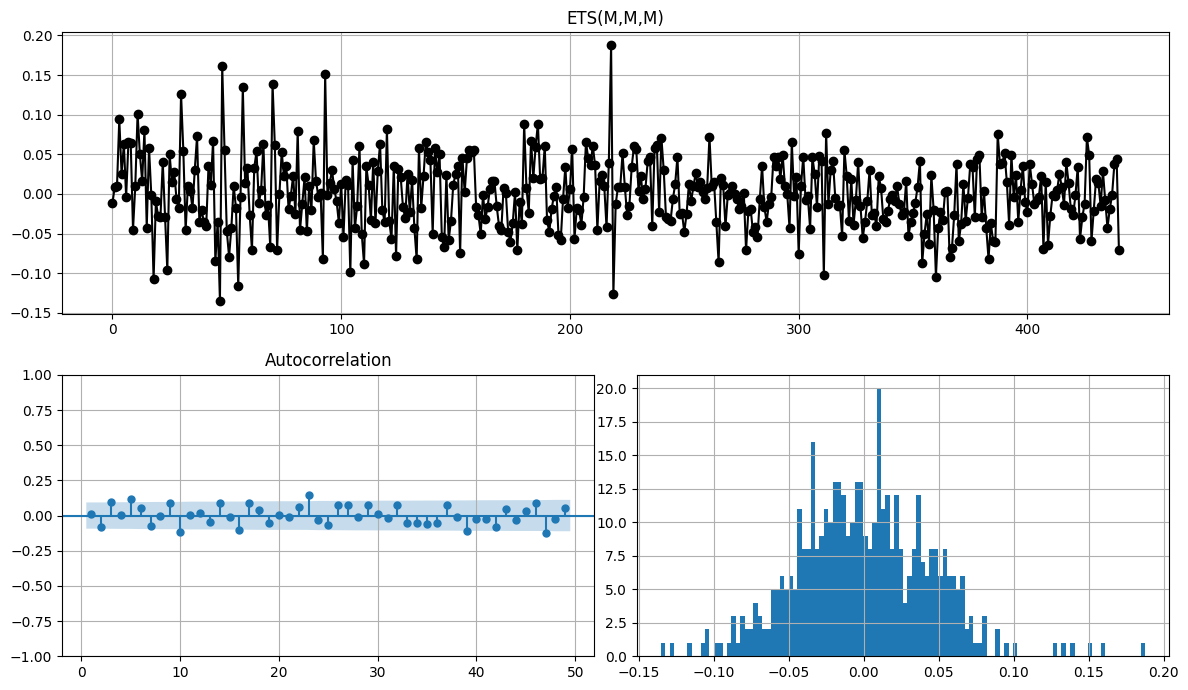

In [213]:
df["resid"] = ets.resid.values

plot_ts_resid(df, "Quarter", y="resid", title="ETS(M,Md,M)", n_lags=range(1, 50))

df["resid"] = ets2.resid.values

plot_ts_resid(df, "Quarter", y="resid", title="ETS(M,M,M)", n_lags=range(1, 50))

##### e) Now find the test set RMSE, while training the model to the end of 2010. Can you beat the seasonal naïve approach from Exercise 7 in Section 5.11?

<Axes: xlabel='Month'>

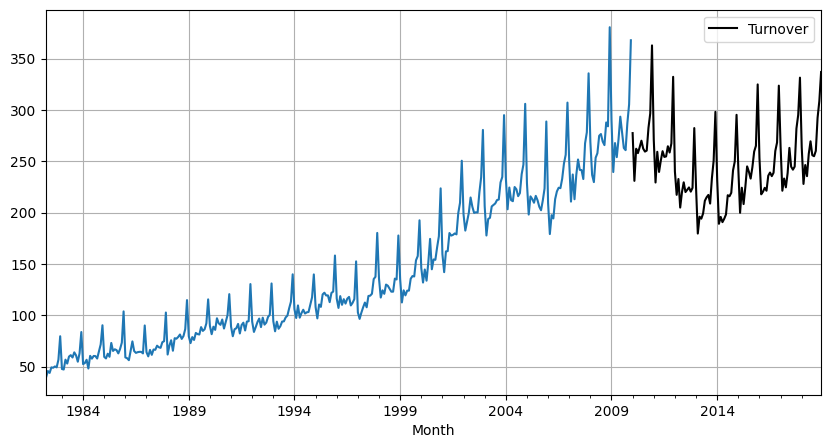

In [219]:
train = df[df["Month"] < "2010-01-01"]
test = df[df["Month"] >= "2010-01-01"].reset_index(drop=True)

ax = train.plot(x="Month", y="Turnover", legend=None, figsize=(10, 5))
test.plot(x="Month", y="Turnover", grid=2, color="k", ax=ax)

In [220]:
ets = ETSModel(
    train.set_index("Month")["Turnover"],
    error="mul",
    trend="mul",
    seasonal="mul",
    damped_trend=True,
    freq="MS"
).fit(disp=0)

ets2 = ETSModel(
    train.set_index("Month")["Turnover"],
    error="mul",
    trend="mul",
    seasonal="mul",
    damped_trend=False,
    freq="MS"
).fit(disp=0)

In [228]:
etsmd = ets.predict(start=test.Month.min(), end=test.Month.max())
etsm = ets2.predict(start=test.Month.min(), end=test.Month.max())

In [229]:
ets_damped_rmse = np.sqrt(mean_squared_error(test["Turnover"], etsmd.values))
ets_no_damped_rmse = np.sqrt(mean_squared_error(test["Turnover"], etsm.values))

ets_damped_rmse, ets_no_damped_rmse

(54.51950096211553, 163.3978324394614)

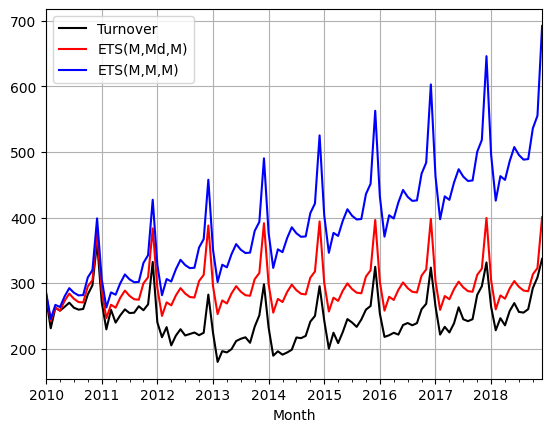

In [241]:
#ax = train.plot(x="Month", y="Turnover", legend=None, figsize=(10, 5))
ax = test.plot(x="Month", y="Turnover", grid=2, color="k")
ax = etsmd.plot(color="r", ax=ax, label="ETS(M,Md,M)")
ax = etsm.plot(color="b", ax=ax, grid=2, label="ETS(M,M,M)")

ax.legend();

#### 9. For the same retail data, try an STL decomposition applied to the Box-Cox transformed series, followed by ETS on the seasonally adjusted data. How does that compare with your best previous forecasts on the test set?

#### 10. Compute the total domestic overnight trips across Australia from the tourism dataset.

##### a) Plot the data and describe the main features of the series.

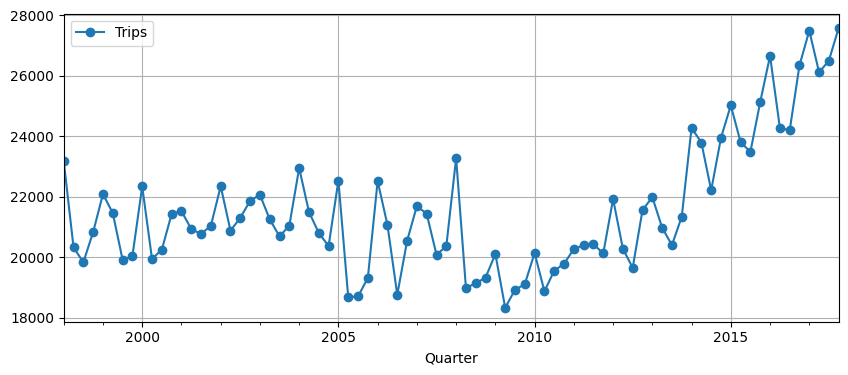

In [107]:
df = pd.read_csv("../data/tourism.csv")
df['Quarter'] = df.Quarter.apply(lambda x: x.replace(' ', '-'))
df['Quarter'] = pd.PeriodIndex(df.Quarter, freq='Q').to_timestamp()

df = df[["Quarter", "Trips"]].groupby("Quarter").sum().reset_index()

df.plot(x="Quarter", grid=2, figsize=(10, 4), marker="o");

- Maybe a Piercewise linear regression looks like a good initial start for fit this trend dataset.
- No seasonal pattern show.
- Looks like a spike on quarter 1, is very clear on data from 2005 to 2010. 

##### b) Decompose the series using STL and obtain the seasonally adjusted data.

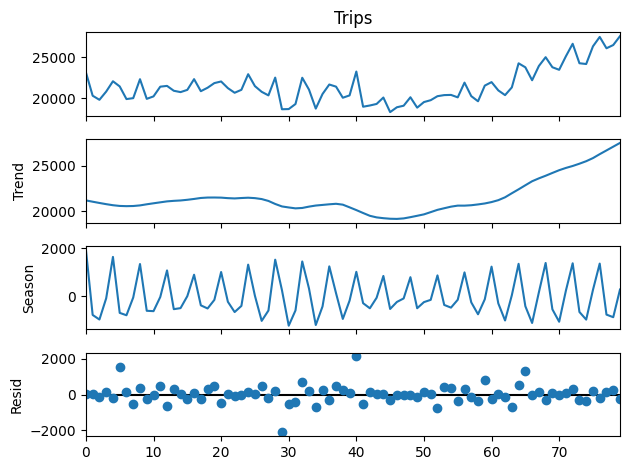

In [130]:
# ETS(A, A, M)

stl = STL(
    df["Trips"],
    robust=True,
    period=4
).fit().plot()

##### c) Forecast the next two years of the series using an additive damped trend method applied to the seasonally adjusted data. (This can be specified using decomposition_model().)

In [117]:
ets = ETSModel(
    df.set_index("Quarter")["Trips"],
    trend="add",
    damped_trend=True,
    freq="QS-JAN"
).fit(disp=0)

ets.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 ETS Results                                  
==============================================================================
Dep. Variable:                  Trips   No. Observations:                   80
Model:                      ETS(AAdN)   Log Likelihood                -681.674
Date:                Wed, 27 Dec 2023   AIC                           1375.347
Time:                        15:19:24   BIC                           1389.639
Sample:                    01-01-1998   HQIC                          1381.077
                         - 10-01-2017   Scale                      1474697.175
Covariance Type:               approx                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
smoothing_level     0.1888      0.096      1.977      0.048       0.002       0.376
smoothing_trend     0.0410      0.024      1.721      0.085      -0.006       0.088
damping_trend       0.9638      0.096     10.032      0.000       0.775       1.152
initial_level    2.157e+04   1203.591     17.925      0.000    1.92e+04    2.39e+04
initial_trend    -105.6313    311.238     -0.339      0.734    -715.646     504.383
===================================================================================
Ljung-Box (Q):                       10.85   Jarque-Bera (JB):                 0.48
Prob(Q):                              0.00   Prob(JB):                         0.79
Heteroskedasticity (H):               1.35   Skew:                            -0.00
Prob(H) (two-sided):                  0.45   Kurtosis:                         2.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

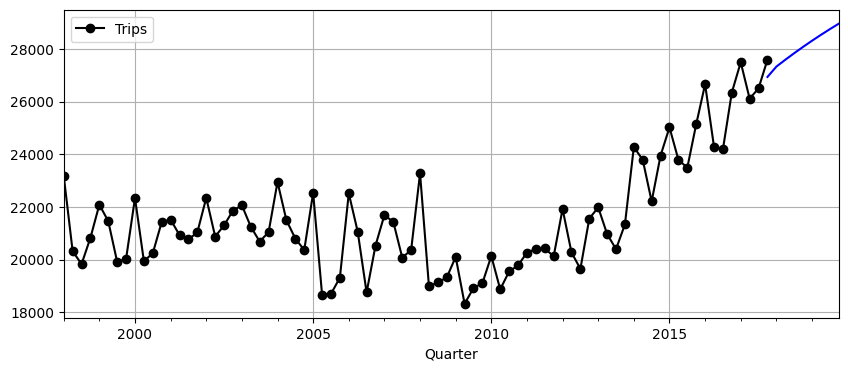

In [129]:
f = ets.predict(start=df.Quarter.max(), end=df.Quarter.max() + pd.offsets.DateOffset(years=2))

ax = df.plot(x="Quarter", grid=2, figsize=(10, 4), marker="o", color="k");
f.plot(ax=ax, grid=2, color="b");

##### d) Forecast the next two years of the series using an appropriate model for Holt’s linear method applied to the seasonally adjusted data (as before but without damped trend).

In [150]:
# ETS(A,A,M)
myets = ETSModel(
    df.set_index("Quarter")["Trips"],
    error="add",
    trend="add",
    seasonal="mul",
    #damped_trend=True,
    freq="QS-JAN"
).fit(disp=0)

myets.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 ETS Results                                  
==============================================================================
Dep. Variable:                  Trips   No. Observations:                   80
Model:                       ETS(AAM)   Log Likelihood                -649.836
Date:                Wed, 27 Dec 2023   AIC                           1319.672
Time:                        15:28:26   BIC                           1343.492
Sample:                    01-01-1998   HQIC                          1329.222
                         - 10-01-2017   Scale                       665316.046
Covariance Type:               approx                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
smoothing_level        0.4377      0.092      4.778      0.000       0.258       0.617
smoothing_trend        0.0434      0.020      2.170      0.030       0.004       0.083
smoothing_seasonal  5.623e-05        nan        nan        nan         nan         nan
initial_level       2.096e+04   1790.616     11.705      0.000    1.74e+04    2.45e+04
initial_trend        -16.1243    168.538     -0.096      0.924    -346.454     314.205
initial_seasonal.0     0.9403      0.081     11.674      0.000       0.782       1.098
initial_seasonal.1     0.9092      0.078     11.683      0.000       0.757       1.062
initial_seasonal.2     0.9300      0.080     11.677      0.000       0.774       1.086
initial_seasonal.3     1.0000      0.085     11.716      0.000       0.833       1.167
===================================================================================
Ljung-Box (Q):                        2.46   Jarque-Bera (JB):                 1.62
Prob(Q):                              0.96   Prob(JB):                         0.44
Heteroskedasticity (H):               1.03   Skew:                             0.08
Prob(H) (two-sided):                  0.93   Kurtosis:                         3.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

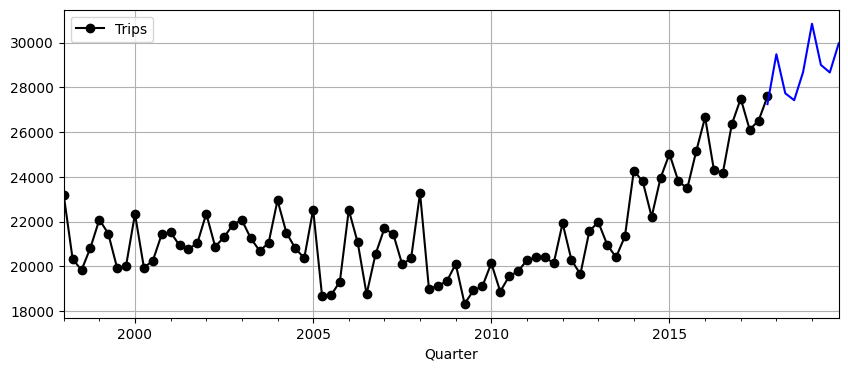

In [132]:
f = myets.predict(start=df.Quarter.max(), end=df.Quarter.max() + pd.offsets.DateOffset(years=2))

ax = df.plot(x="Quarter", grid=2, figsize=(10, 4), marker="o", color="k");
f.plot(ax=ax, grid=2, color="b");

##### e) Now use ETS() to choose a seasonal model for the data.

In [133]:
ets = AutoETS(season_length=4).fit(df["Trips"].to_numpy())

ets.model_

{'loglik': -709.184964361716,
 'aic': 1436.369928723432,
 'bic': 1457.8081684354968,
 'aicc': 1438.9413572948606,
 'mse': 626307.957727863,
 'amse': 777593.6154319964,
 'fit': results(x=array([ 4.35992774e-01,  4.41451580e-02,  1.05398027e-04,  2.12652802e+04,
        -2.86416765e+01, -1.22143849e+02, -8.15231366e+02, -3.47490576e+02]), fn=1418.369928723432, nit=470, simplex=array([[ 4.36673731e-01,  4.39166819e-02,  1.00000000e-04,
          2.12662996e+04, -2.76588812e+01, -1.23497389e+02,
         -8.16023264e+02, -3.46008347e+02],
        [ 4.37680255e-01,  4.43290414e-02,  1.05109028e-04,
          2.12549381e+04, -2.76456172e+01, -1.21324536e+02,
         -8.14433335e+02, -3.48494499e+02],
        [ 4.36950690e-01,  4.39404691e-02,  1.04497356e-04,
          2.12599813e+04, -2.86202040e+01, -1.20917274e+02,
         -8.16202449e+02, -3.47918518e+02],
        [ 4.35992774e-01,  4.41451580e-02,  1.05398027e-04,
          2.12652802e+04, -2.86416765e+01, -1.22143849e+02,
         -8

In [148]:
ets.model_["method"]

'ETS(A,A,A)'

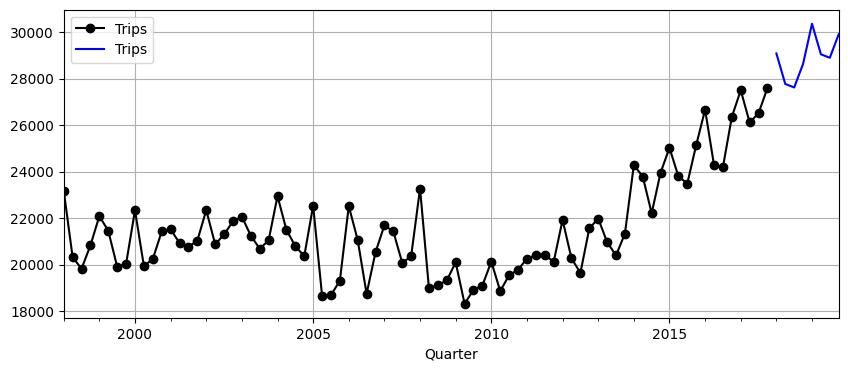

In [147]:
f = pd.DataFrame(ets.predict(4 * 2)["mean"], index=f.index[1:]).rename(columns={0: "Trips"})

ax = df.plot(x="Quarter", grid=2, figsize=(10, 4), marker="o", color="k");
f.plot(ax=ax, grid=2, color="b");

##### f) Compare the RMSE of the ETS model with the RMSE of the models you obtained using STL decompositions. Which gives the better in-sample fits?

In [170]:
np.sqrt(ets.model_["mse"])

791.3962078048284

In [169]:
auto_ets_rmse = np.sqrt(mean_squared_error(df["Trips"].values, ets.model_["fitted"]))
my_ets_rmse = np.sqrt(mean_squared_error(df["Trips"].values, myets.fittedvalues.values))

print(f"ETS(A,A,M): {my_ets_rmse:.4f}\n{ets.model_['method']}: {auto_ets_rmse:.4f}")

ETS(A,A,M): 815.6691
ETS(A,A,A): 791.3962


##### g) Compare the forecasts from the three approaches? Which seems most reasonable?

Looks like all two good to me.

One approach i can use is to forecast with two models and make a mean of all two values per quarter in future.

##### h) Check the residuals of your preferred model.

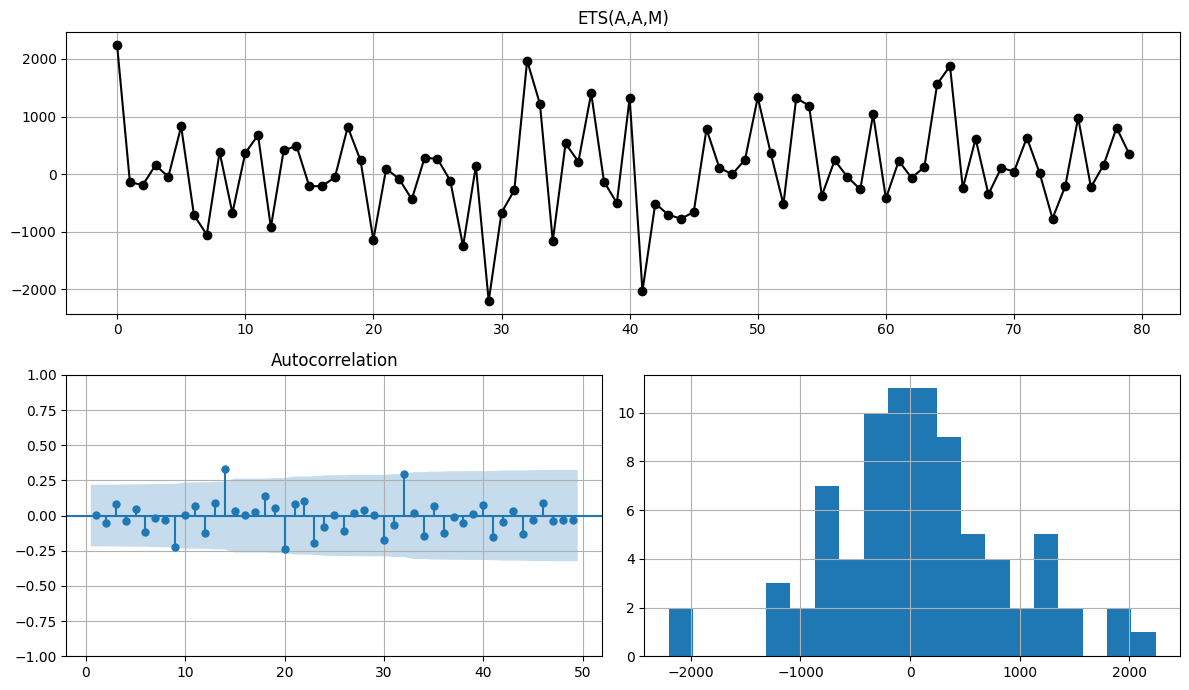

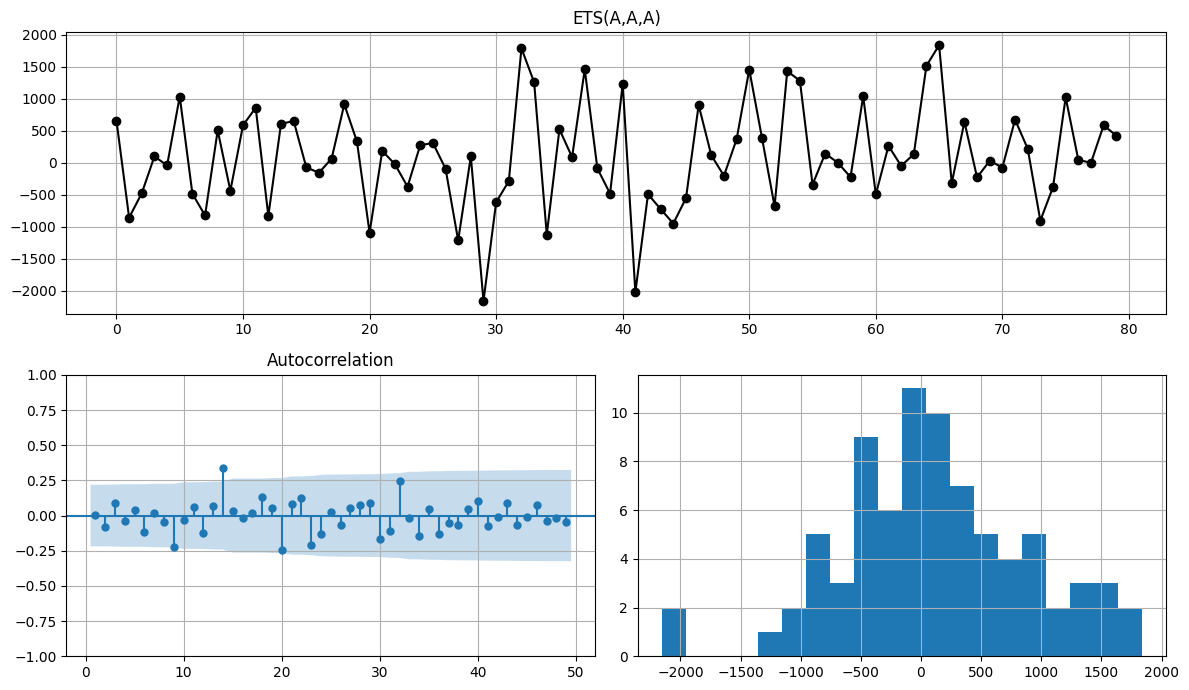

In [184]:
df["resid"] = myets.resid.values

plot_ts_resid(df, "Quarter", y="resid", title="ETS(A,A,M)", n_lags=range(1, 50))

df["resid"] = ets.model_["actual_residuals"]

plot_ts_resid(df, "Quarter", y="resid", title="ETS(A,A,A)", n_lags=range(1, 50))

#### 11. For this exercise use the quarterly number of arrivals to Australia from New Zealand, 1981 Q1 – 2012 Q3, from data set aus_arrivals.

In [302]:
df = pd.read_csv("../data/aus_arrivals.csv", index_col=[0])
df = df[df["Origin"] == "NZ"].reset_index(drop=True)

df['Quarter'] = df.Quarter.apply(lambda x: x.replace(' ', '-'))
df['Quarter'] = pd.PeriodIndex(df.Quarter, freq='Q').to_timestamp()

##### a) Make a time plot of your data and describe the main features of the series.

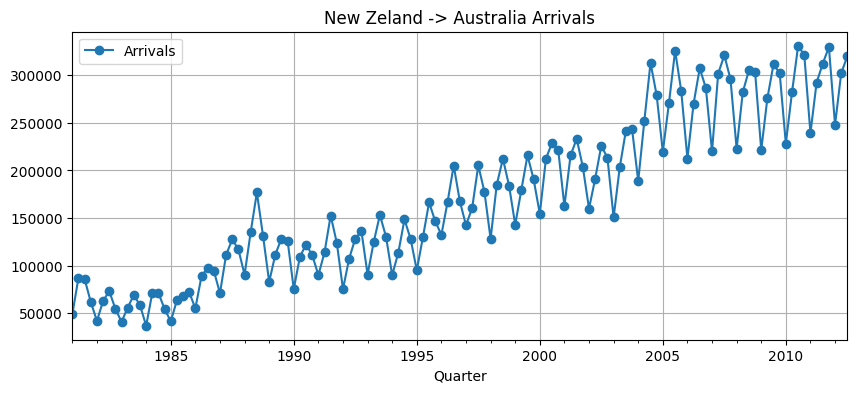

In [303]:
df.plot(x="Quarter", grid=2, figsize=(10, 4), title="New Zeland -> Australia Arrivals", marker="o");

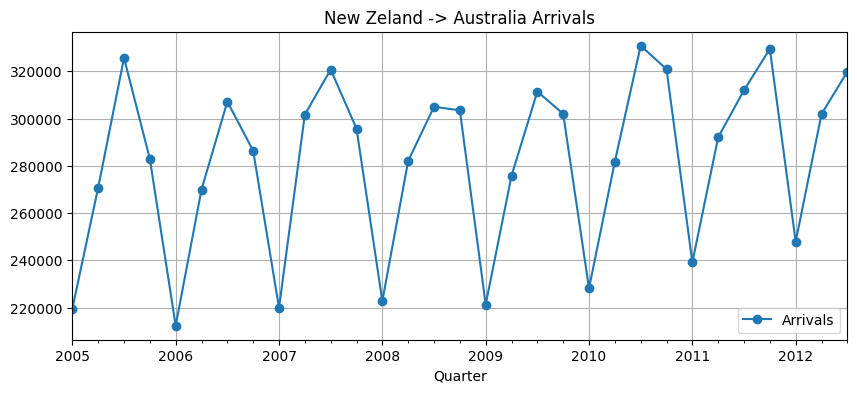

In [304]:
df = df[df["Quarter"] >= "2005-01-01"].reset_index(drop=True)

df.plot(x="Quarter", grid=2, figsize=(10, 4), title="New Zeland -> Australia Arrivals", marker="o");

- Clear Trend;
- Clear Seasonality;
- Looks Like very noisy before 85's.
- I will filter the values greather than 2005. 

##### b) Create a training set that withholds the last two years of available data. Forecast the test set using an appropriate model for Holt-Winters’ multiplicative method.

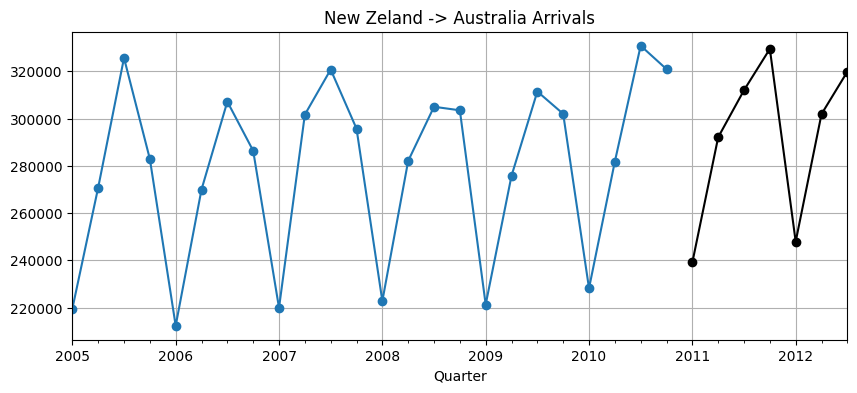

In [310]:
train = df[df.Quarter.dt.year < 2011]
test = df[df.Quarter.dt.year >= 2011]

ax = train.plot(x="Quarter", figsize=(10, 4), title="New Zeland -> Australia Arrivals", marker="o", legend=None);
test.plot(x="Quarter", grid=2, ax=ax, color="k", marker="o", legend=None);

##### c) Why is multiplicative seasonality necessary here?

Do not need a multiplicative seasonality.

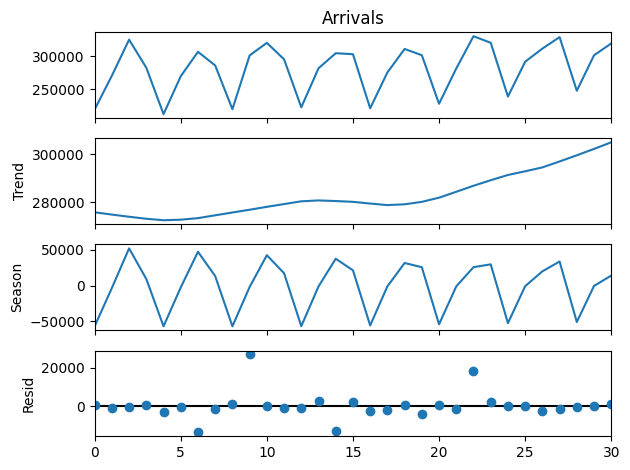

In [312]:
stl = STL(df["Arrivals"], robust=True, period=4).fit().plot()

##### a) Forecast the two-year test set using each of the following methods:

- an ETS model;
- an additive ETS model applied to a log transformed series;
- a seasonal naïve method;
- an STL decomposition applied to the log transformed data followed by an ETS model applied to the seasonally adjusted (transformed) data.

#### 12. Apply cross-validation techniques to produce 1 year ahead ETS and seasonal naïve forecasts for Portland cement production (from aus_production). 

In [7]:
df = pd.read_csv("../data/aus_production.csv", index_col=[0])
df = df[["Quarter", "Cement"]]

df['Quarter'] = df.Quarter.apply(lambda x: x.replace(' ', '-'))
df['Quarter'] = pd.PeriodIndex(df.Quarter, freq='Q').to_timestamp()

Apply cross-validation techniques to produce 1 year ahead ETS and seasonal naïve forecasts for Portland cement production (from aus_production). Use a stretching data window with initial size of 5 years, and increment the window by one observation.

By One observation or by one year ?

If i use one observation, the seasonal naive get wrong because i have quarter data.

In [41]:
# First 5 years
df_base = df[df.Quarter < f"{df.Quarter.dt.year.min() + 5}-01-01"]

# Next Cross Validation Years
next_years = df.loc[df.Quarter > df_base.Quarter.max() + pd.DateOffset(years=1), "Quarter"].dt.year.unique()

In [ ]:
metrics = []

for year in next_years:
    if year == 2010:
        break
    
    train = df[df.Quarter < f"{year}-01-01"].reset_index(drop=True)
    test = df[(df.Quarter >= f"{year}-01-01") & (df.Quarter <= f"{year}-12-31")].reset_index(drop=True)

    train.columns = ["ds", "y"]
    train["unique_id"] = "a"

    test.columns = ["ds", "y"]
    test["unique_id"] = "a"

    sf = StatsForecast(
        models=[AutoETS(season_length=4), SeasonalNaive(season_length=4)],
        freq="QS-JAN"
    ).fit(train)

    f = sf.forecast(4)

    ets_rmse = np.sqrt(mean_squared_error(test["y"].values, f["AutoETS"].values))
    sn_rmse = np.sqrt(mean_squared_error(test["y"].values, f["SeasonalNaive"].values))

    metrics.append({"cv_year": year, "ets_rmse": ets_rmse, "sn_rmse": sn_rmse})

    del sf, f

Seasonal Naive looks like very close to ets models, i choose seasonal naive because is very more easy to explain and to forecast next observations in future.

In [91]:
pd.DataFrame(metrics)

,cv_year,ets_rmse,sn_rmse
0,1962,54.410638,47.188452
1,1963,27.315676,52.256579
2,1964,55.837232,126.287371
3,1965,53.054775,64.009765
4,1966,64.656200,35.397740
5,1967,29.876523,43.069711
6,1968,18.452882,39.877939
7,1969,65.208051,101.522165
8,1970,19.796698,78.787689
9,1971,40.295145,52.036045


#### 13. Compare ETS(), SNAIVE() and decomposition_model(STL, ???) on the following five time series. 

##### a) Beer and Bricks production for Aus_production. 

In [119]:
df = pd.read_csv("../data/aus_production.csv")
df['Quarter'] = df.Quarter.apply(lambda x: x.replace(' ', '-'))
df['Quarter'] = pd.PeriodIndex(df.Quarter, freq='Q').to_timestamp()

df = df[["Quarter", "Beer", "Bricks"]]

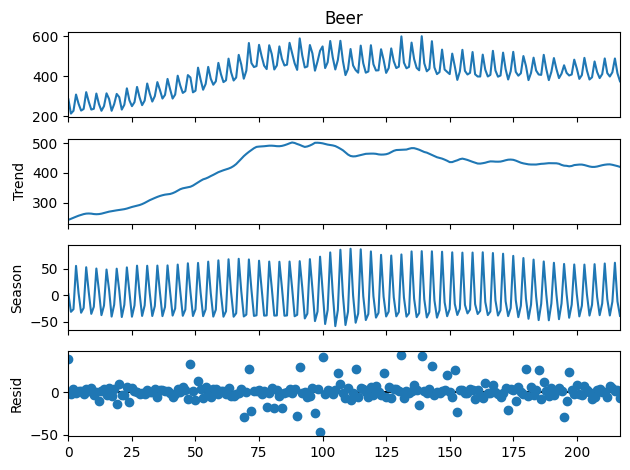

In [100]:
s = STL(
    df["Beer"],
    robust=True,
    period=4
).fit().plot();


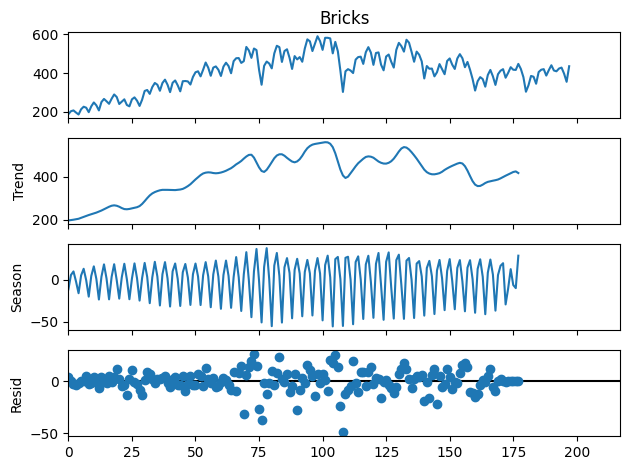

In [105]:
s = STL(
    df["Bricks"],
    robust=False,
    period=4
).fit().plot();

In [120]:
df.dropna(inplace=True)
df = df.melt(id_vars=["Quarter"], value_vars=["Beer", "Bricks"])

In [127]:
df[df.Quarter == "1956-01-01"]

,Quarter,variable,value
0,1956-01-01,Beer,284.0
198,1956-01-01,Bricks,189.0


In [128]:
df.columns = ["ds", "unique_id", "y"]

In [129]:
sf = StatsForecast(
    models=[
        AutoETS(season_length=4),
        SeasonalNaive(season_length=4)
    ],
    freq="QS-JAN"
).fit(df)

In [130]:
sf.forecast(4)

,ds,AutoETS,SeasonalNaive
unique_id,,,
Beer,2005-07-01,402.891907,412.0
Beer,2005-10-01,482.082520,454.0
Beer,2006-01-01,420.280701,416.0
Beer,2006-04-01,385.373901,403.0
Bricks,2005-07-01,449.746857,428.0
Bricks,2005-10-01,426.144897,397.0
Bricks,2006-01-01,384.850586,355.0
Bricks,2006-04-01,434.994263,435.0


##### b) Cost of drug subsidies for diabetes (ATC2 == "A10") and corticosteroids (ATC2 == "H02") from PBS.

In [141]:
df = pd.read_csv("../data/PBS.csv", index_col=[0])

df = df[df["ATC2"].isin(["A10", "H02"])].reset_index(drop=True)

df["Month"] = pd.to_datetime(df["Month"], format="%Y %b")

df = df[["Month", "ATC2", "Cost"]].groupby(["Month", "ATC2"]).sum().reset_index()

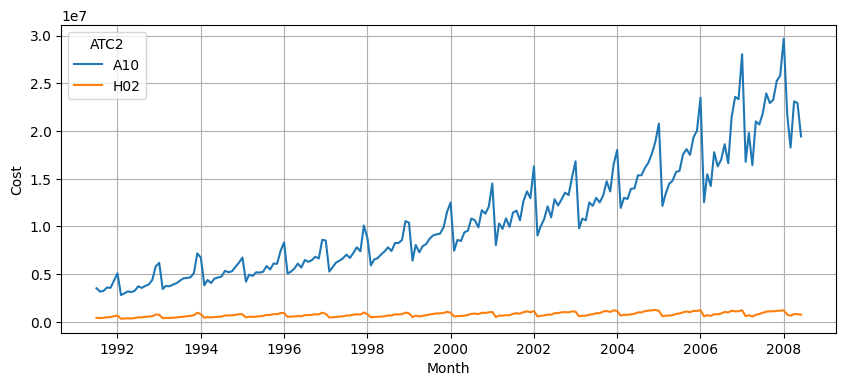

In [146]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(df, x="Month", y="Cost", hue="ATC2", ax=ax)
ax.grid(2)

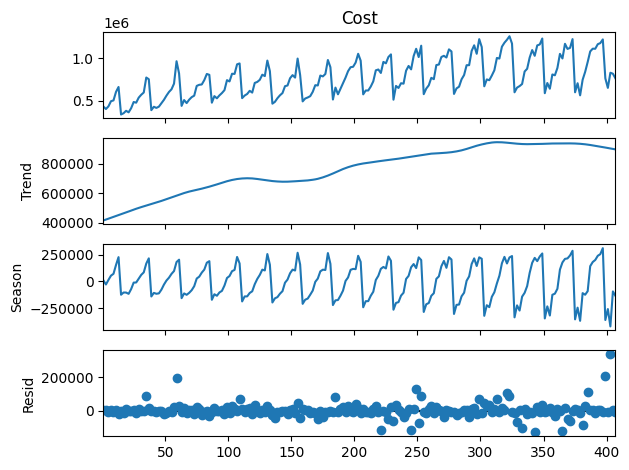

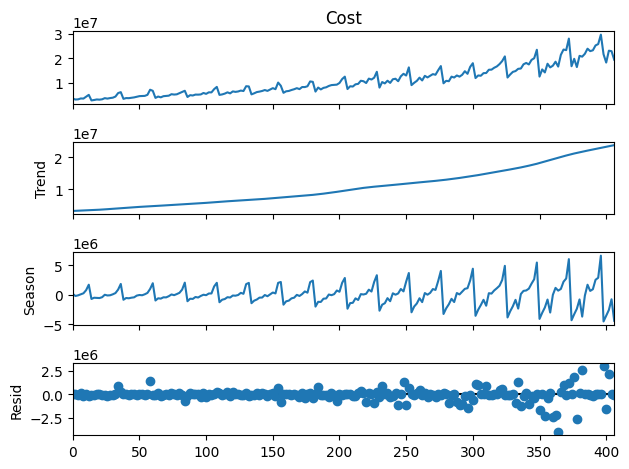

In [151]:
s = STL(
    df[df["ATC2"] == "H02"]["Cost"],
    robust=True,
    period=12
).fit().plot();

s = STL(
    df[df["ATC2"] == "A10"]["Cost"],
    robust=True,
    period=12
).fit().plot();

In [155]:
df.columns = ["ds", "unique_id", "y"]

In [157]:
sf = StatsForecast(
    models=[
        AutoETS(season_length=4),
        SeasonalNaive(season_length=4)
    ],
    freq="MS"
).fit(df)

sf.forecast(12)

,ds,AutoETS,SeasonalNaive
unique_id,,,
A10,2008-07-01,2.046530e+07,18264944.0
A10,2008-08-01,2.144818e+07,23107676.0
A10,2008-09-01,2.238708e+07,22912510.0
A10,2008-10-01,2.024235e+07,19431740.0
A10,2008-11-01,2.091028e+07,18264944.0
A10,2008-12-01,2.191201e+07,23107676.0
A10,2009-01-01,2.286861e+07,22912510.0
A10,2009-02-01,2.067541e+07,19431740.0
A10,2009-03-01,2.135525e+07,18264944.0


##### c) Total food retailing turnover for Australia from aus_retail.

In [178]:
df = pd.read_csv("../data/aus_retail.csv")

df = df[df.Industry == 'Food retailing']

df = df[["Month", "Turnover"]].groupby("Month").sum().reset_index()

df["Month"] = pd.to_datetime(df["Month"], format="%Y %b")

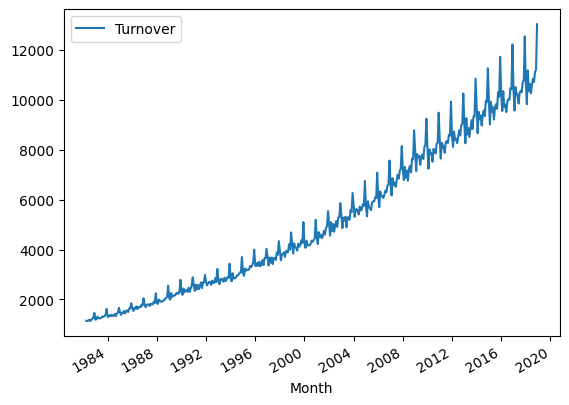

In [170]:
df.plot(x="Month");

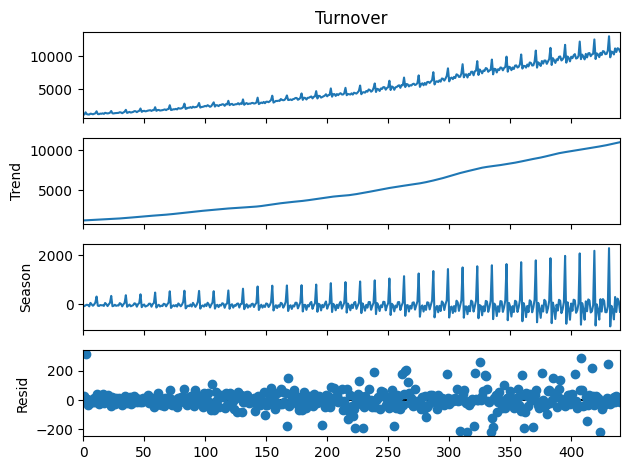

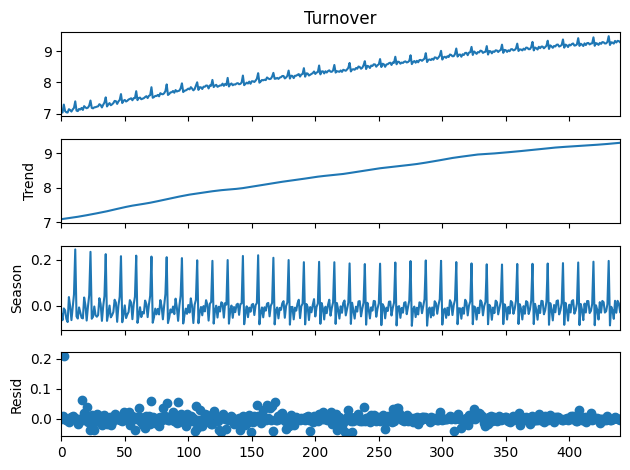

In [168]:
stl = STL(
    df["Turnover"],
    period=12,
    robust=True
).fit().plot();

stl = STL(
    np.log(df["Turnover"]),
    period=12,
    robust=True
).fit().plot();

In [172]:
df.columns = ["ds", "y"]
df["unique_id"] = "Food retailing"

In [173]:
sf = StatsForecast(
    models=[
        AutoETS(season_length=4),
        SeasonalNaive(season_length=4)
    ],
    freq="MS"
).fit(df)

sf.forecast(12)

,ds,AutoETS,SeasonalNaive
unique_id,,,
Food retailing,2019-01-01,10979.518555,10713.900391
Food retailing,2019-02-01,10803.091797,11126.000000
Food retailing,2019-03-01,11218.297852,11214.700195
Food retailing,2019-04-01,11787.117188,13037.500000
Food retailing,2019-05-01,11104.437500,10713.900391
Food retailing,2019-06-01,10925.655273,11126.000000
Food retailing,2019-07-01,11345.210938,11214.700195
Food retailing,2019-08-01,11920.089844,13037.500000
Food retailing,2019-09-01,11229.355469,10713.900391


#### 14. Use ETS() to select an appropriate model for the following series. 

##### a) total number of trips across Australia using tourism.

In [263]:
df = pd.read_csv("../data/tourism.csv")

df = df[["Quarter", "Trips"]].groupby("Quarter").sum().reset_index()

df['Quarter'] = df.Quarter.apply(lambda x: x.replace(' ', '-'))
df['Quarter'] = pd.PeriodIndex(df.Quarter, freq='Q').to_timestamp()

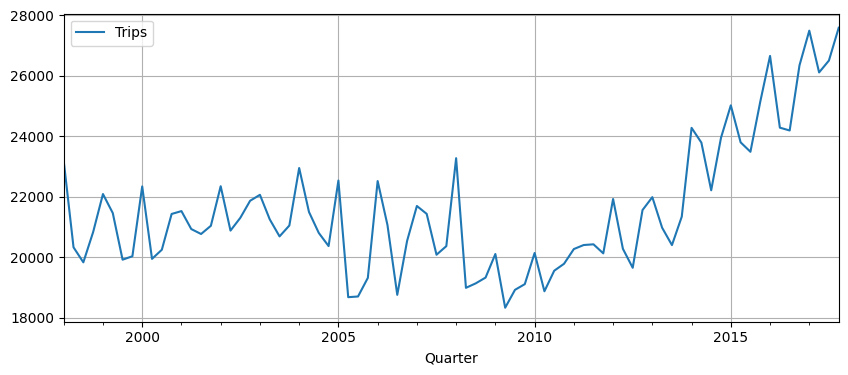

In [276]:
df.plot(x="Quarter", figsize=(10, 4), grid=2);

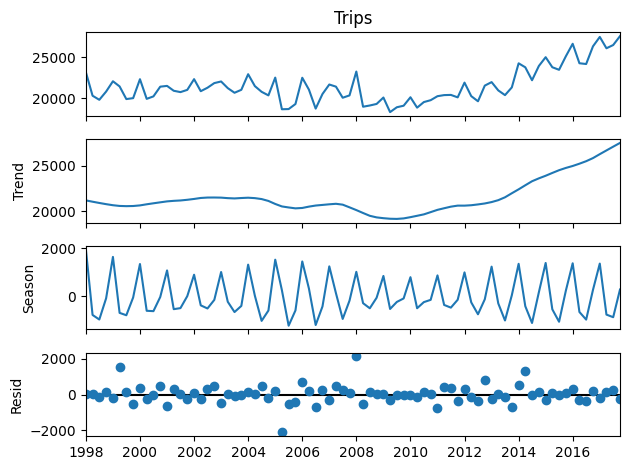

In [284]:
STL(df.set_index("Quarter")["Trips"], robust=True).fit().plot();

In [260]:
e = AutoETS(season_length=4).fit(df["Trips"].to_numpy())

In [275]:
future_df = pd.date_range(start=df.Quarter.max(), end=df.Quarter.max() + pd.offsets.DateOffset(years=2), freq="QS")[1:]
future_df = pd.DataFrame(future_df)
future_df.columns = ["Quarter"]

future_df["Trips"] = e.predict(4 * 2)["mean"]

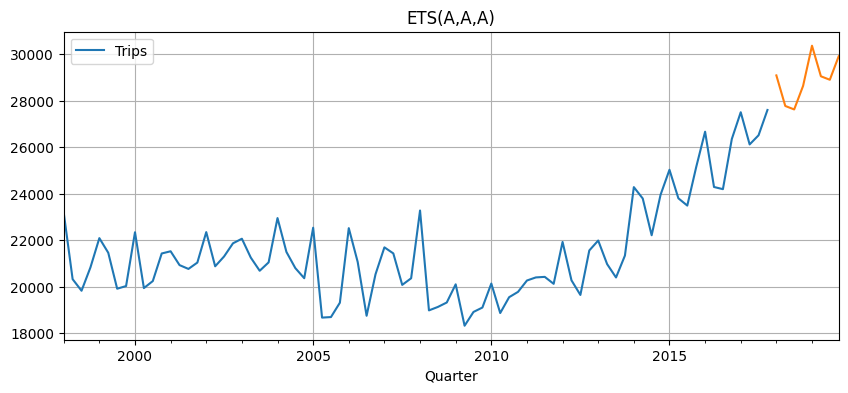

In [282]:
ax = df.plot(x="Quarter", figsize=(10, 4), grid=2)
future_df.plot(x="Quarter", ax=ax, grid=2, legend=None, title=e.model_["method"]);

In [261]:
e.model_

{'loglik': -709.184964361716,
 'aic': 1436.369928723432,
 'bic': 1457.8081684354968,
 'aicc': 1438.9413572948606,
 'mse': 626307.957727863,
 'amse': 777593.6154319964,
 'fit': results(x=array([ 4.35992774e-01,  4.41451580e-02,  1.05398027e-04,  2.12652802e+04,
        -2.86416765e+01, -1.22143849e+02, -8.15231366e+02, -3.47490576e+02]), fn=1418.369928723432, nit=470, simplex=array([[ 4.36673731e-01,  4.39166819e-02,  1.00000000e-04,
          2.12662996e+04, -2.76588812e+01, -1.23497389e+02,
         -8.16023264e+02, -3.46008347e+02],
        [ 4.37680255e-01,  4.43290414e-02,  1.05109028e-04,
          2.12549381e+04, -2.76456172e+01, -1.21324536e+02,
         -8.14433335e+02, -3.48494499e+02],
        [ 4.36950690e-01,  4.39404691e-02,  1.04497356e-04,
          2.12599813e+04, -2.86202040e+01, -1.20917274e+02,
         -8.16202449e+02, -3.47918518e+02],
        [ 4.35992774e-01,  4.41451580e-02,  1.05398027e-04,
          2.12652802e+04, -2.86416765e+01, -1.22143849e+02,
         -8

##### b) the closing prices for the four stocks in gafa_stock.

In [310]:
df = pd.read_csv("../data/gafa_stock.csv")

df = df[["Date", "Symbol", "Close"]]

df["Date"] = pd.to_datetime(df["Date"])

df.columns = ["ds", "unique_id", "y"]

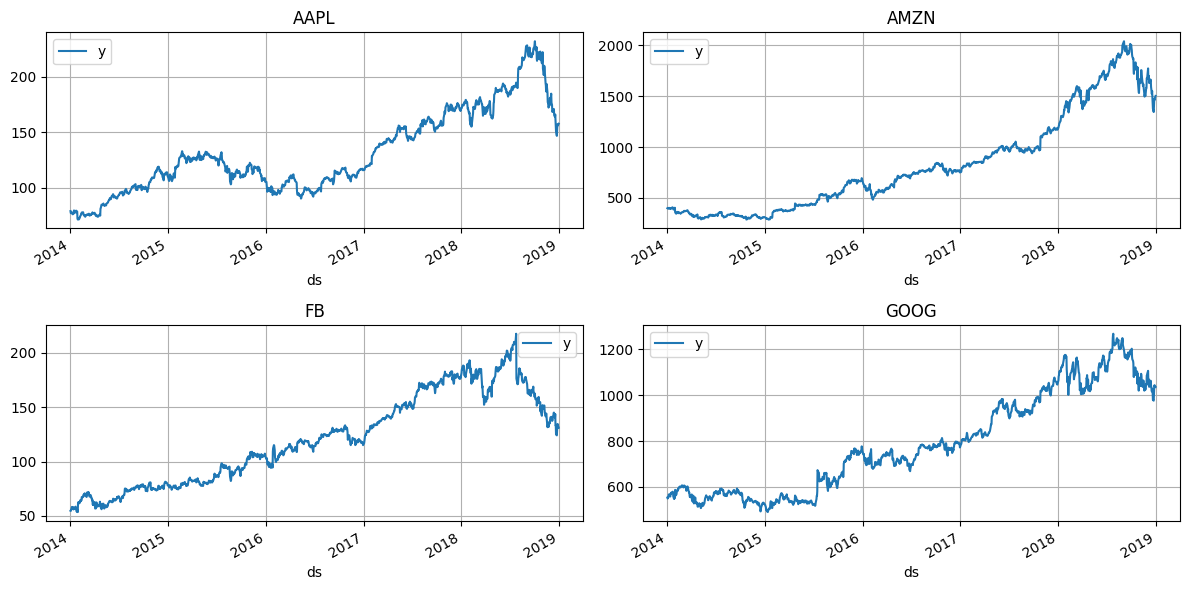

In [317]:
fig, ax = plt.subplots(2, 2, figsize=(12, 6))
ax = ax.flatten()

for axi, u in zip(ax, df.unique_id.unique()):
    df[df.unique_id == u].plot(x="ds", y="y", ax=axi)
    axi.set_title(u)
    axi.grid(2)

plt.tight_layout()

In [289]:
sf = StatsForecast(
    models=[AutoETS()],
    freq="QS-JAN"
).fit(df)

f = sf.forecast(10)
f = f.reset_index()

In [302]:
f

,unique_id,ds,AutoETS
0,AAPL,2019-01-01,157.739853
1,AAPL,2019-04-01,157.739853
2,AAPL,2019-07-01,157.739853
3,AAPL,2019-10-01,157.739853
4,AAPL,2020-01-01,157.739853
5,AAPL,2020-04-01,157.739853
6,AAPL,2020-07-01,157.739853
7,AAPL,2020-10-01,157.739853
8,AAPL,2021-01-01,157.739853
9,AAPL,2021-04-01,157.739853


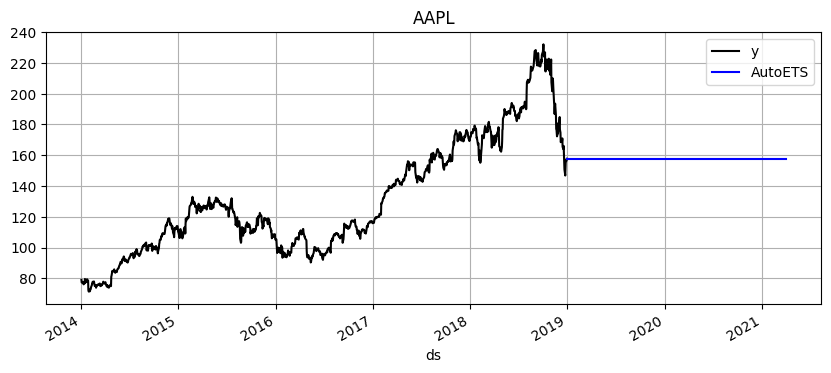

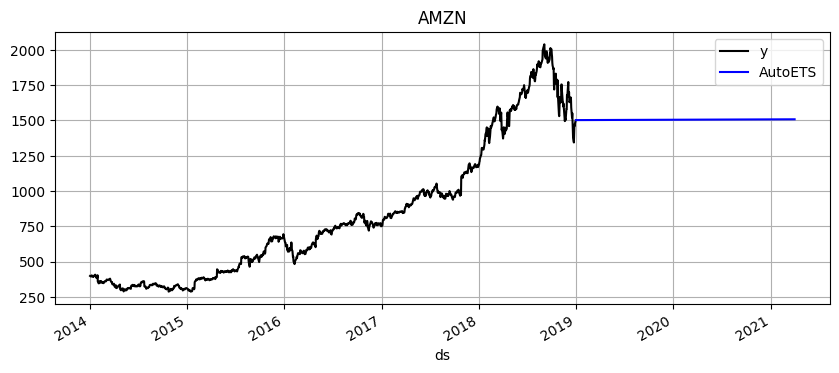

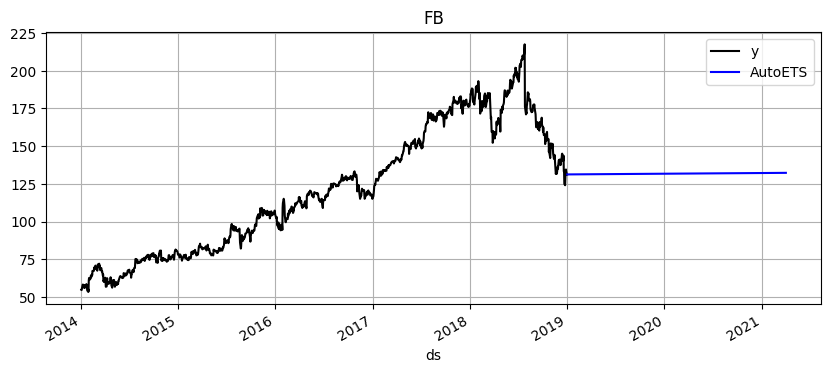

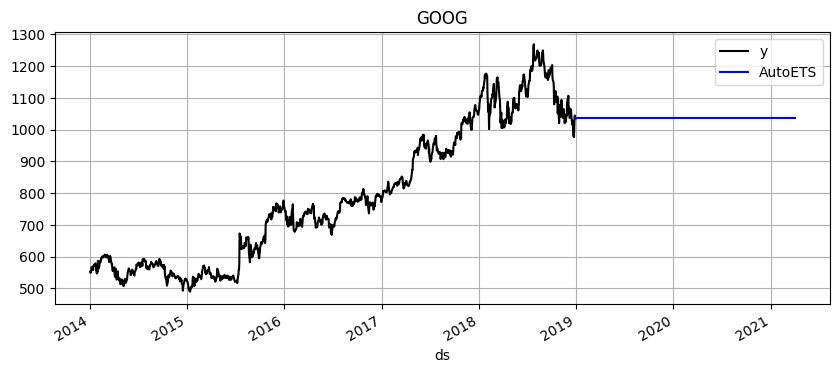

In [301]:
for u in df.unique_id.unique():
    fig, ax = plt.subplots(figsize=(10, 4))
    
    df[df["unique_id"] == u].plot(x="ds", y="y", color="k", ax=ax)
    f[f.unique_id == u].plot(x="ds", y="AutoETS", color="b", ax=ax)
    
    ax.set_title(u)
    ax.grid(2)

##### c) the lynx series in pelt.

In [320]:
df = pd.read_csv("../data/pelt.csv")

df = df[["Year", "Lynx"]]

df["Year"] = pd.to_datetime(df["Year"], format="%Y")

df.plot(x="Year", color="k", grid=2, figsize=(10, 4));

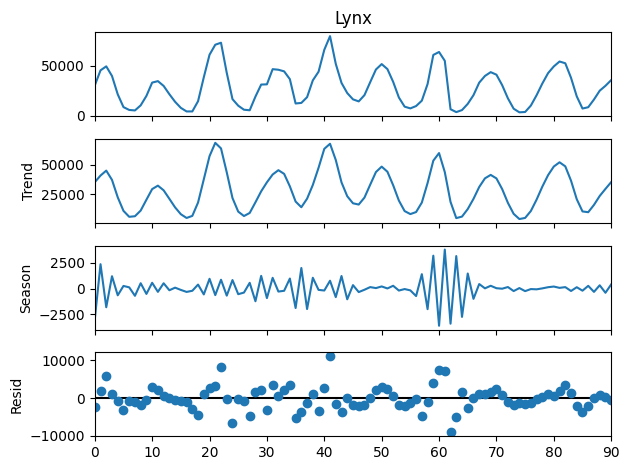

In [330]:
STL(df["Lynx"], period=2).fit().plot();

In [332]:
e = AutoETS(season_length=1).fit(df["Lynx"].to_numpy())

e.model_

{'loglik': -923.3178519708947,
 'aic': 1858.6357039417894,
 'bic': 1873.7008609808904,
 'aicc': 1859.6357039417894,
 'mse': 172960411.22556236,
 'amse': 577820647.7301624,
 'fit': results(x=array([9.99899955e-01, 1.00140673e-04, 9.79999935e-01, 1.82636763e+04,
        7.45387874e+03]), fn=2112.0183606251994, nit=208, simplex=array([[9.99899879e-01, 1.00151403e-04, 9.79999951e-01, 1.82431841e+04,
         7.42020869e+03],
        [9.99899932e-01, 1.00156878e-04, 9.79999968e-01, 1.84733619e+04,
         7.42674820e+03],
        [9.99900000e-01, 1.00184429e-04, 9.79999954e-01, 1.84893381e+04,
         7.43893276e+03],
        [9.99899958e-01, 1.00186020e-04, 9.79999923e-01, 1.82175088e+04,
         7.44710809e+03],
        [9.99899955e-01, 1.00140673e-04, 9.79999935e-01, 1.82636763e+04,
         7.45387874e+03],
        [9.99900000e-01, 1.00163119e-04, 9.80000000e-01, 1.84768855e+04,
         7.41323785e+03]])),
 'residuals': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [344]:
forecast = pd.DataFrame(pd.date_range(start=df.Year.max(), end=df.Year.max() + pd.offsets.DateOffset(years=10), freq="YS")[1:])
forecast.columns = ["Year"]
forecast["Lynx"] = e.predict(10)["mean"]

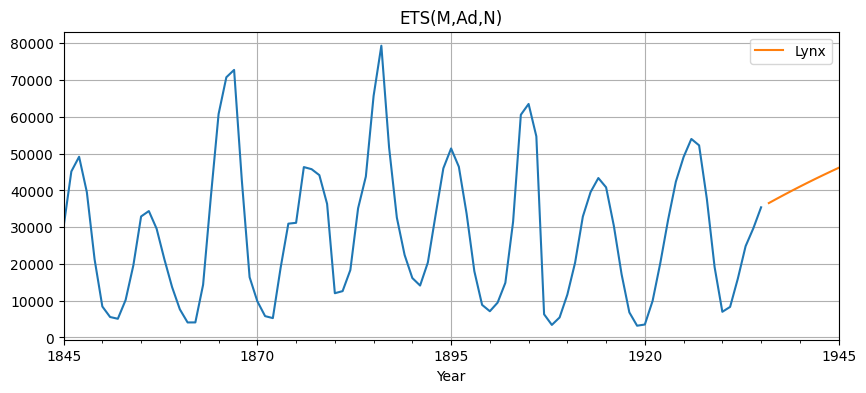

In [353]:
ax = df.plot(x="Year", figsize=(10, 4), title=e.model_["method"], legend=None)
forecast.plot(x="Year", ax=ax, grid=2);

##### d) Find an example where it does not work well. Can you figure out why?.

The lynx dataset is a yearly data and the autoets is minimizing one feature, for example aicc, but is trend, clearly the all past observations is not trend, maybe a seasonal naive for a hope to catch cycles with much experience on lynx traping guys can help forecast this. 

#### 15. Show that the point forecasts from an ETS(M,A,M) model are the same as those obtained using Holt-Winters’ multiplicative method.

Mathematically the formula should be the same, as it is included in one of the videos in the book about ETS in chapter 8.

In [179]:
df = pd.read_csv("../data/aus_retail.csv")

df = df[df.Industry == 'Food retailing']

df = df[["Month", "Turnover"]].groupby("Month").sum().reset_index()

df["Month"] = pd.to_datetime(df["Month"], format="%Y %b")

In [186]:
df = df.set_index("Month").resample("MS").sum()

In [205]:
h = ExponentialSmoothing(
    df["Turnover"],
    trend="add",
    seasonal="mul",
    freq="MS",
    seasonal_periods=12
).fit()

e = ETSModel(
    df["Turnover"],
    error="mul",
    trend="add",
    seasonal="mul",
    freq="MS",
    seasonal_periods=12
).fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.19292D+00    |proj g|=  2.46687D+00

At iterate    1    f=  6.71526D+00    |proj g|=  1.04476D+00

At iterate    2    f=  6.06033D+00    |proj g|=  9.33345D-01

At iterate    3    f=  6.00482D+00    |proj g|=  8.93939D-01

At iterate    4    f=  5.93372D+00    |proj g|=  4.40819D-01

At iterate    5    f=  5.90922D+00    |proj g|=  4.70098D-01

At iterate    6    f=  5.89364D+00    |proj g|=  1.65318D-01

At iterate    7    f=  5.89057D+00    |proj g|=  1.26831D-01

At iterate    8    f=  5.88657D+00    |proj g|=  1.16096D-01

At iterate    9    f=  5.88554D+00    |proj g|=  1.11515D-01

At iterate   10    f=  5.88407D+00    |proj g|=  1.07173D-01

At iterate   11    f=  5.87281D+00    |proj g|=  2.54525D-01

At iterate   12    f=  5.86817D+00    |proj g|=  1.25793D-01

At iterate   13    f=  5.8

In [208]:
h.summary()

Dep. Variable:,Turnover,No. Observations:,441
Model:,ExponentialSmoothing,SSE,3464891.506
Optimized:,True,AIC,3987.394
Trend:,Additive,BIC,4052.819
Seasonal:,Multiplicative,AICC,3989.015
Seasonal Periods:,12,Date:,"Fri, 29 Dec 2023"
Box-Cox:,False,Time:,17:07:21
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.2467351,alpha,True
smoothing_trend,0.0342662,beta,True


In [207]:
e.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 ETS Results                                  
==============================================================================
Dep. Variable:               Turnover   No. Observations:                  441
Model:                       ETS(MAM)   Log Likelihood               -2569.219
Date:                Fri, 29 Dec 2023   AIC                           5174.438
Time:                        17:07:18   BIC                           5248.040
Sample:                    04-01-1982   HQIC                          5203.471
                         - 12-01-2018   Scale                            0.000
Covariance Type:               approx                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.2272      0.023      9.921      0.000       0.182       0.272
smoothing_trend         0.0133      0.008      1.621      0.105      -0.003       0.029
smoothing_seasonal   7.728e-05        nan        nan        nan         nan         nan
initial_level        1123.8344        nan        nan        nan         nan         nan
initial_trend           9.5399        nan        nan        nan         nan         nan
initial_seasonal.0      1.0406        nan        nan        nan         nan         nan
initial_seasonal.1      0.9594        nan        nan        nan         nan         nan
initial_seasonal.2      1.0317        nan        nan        nan         nan         nan
initial_seasonal.3      1.1942        nan        nan        nan         nan         nan
initial_seasonal.4      1.0387        nan        nan        nan         nan         nan
initial_seasonal.5      1.0418        nan        nan        nan         nan         nan
initial_seasonal.6      0.9960        nan        nan        nan         nan         nan
initial_seasonal.7      1.0171        nan        nan        nan         nan         nan
initial_seasonal.8      1.0081        nan        nan        nan         nan         nan
initial_seasonal.9      0.9737        nan        nan        nan         nan         nan
initial_seasonal.10     1.0106        nan        nan        nan         nan         nan
initial_seasonal.11     1.0000        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (Q):                      729.93   Jarque-Bera (JB):                 4.22
Prob(Q):                              0.00   Prob(JB):                         0.12
Heteroskedasticity (H):               0.30   Skew:                            -0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

In [203]:
display(h.predict())
display(e.forecast())

2019-01-01    11242.762401
Freq: MS, dtype: float64

2019-01-01    11174.340066
Freq: MS, dtype: float64

#### 16. Show that the forecast variance for an ETS(A,N,N) model is given by

$\sigma^2\left[1+\alpha^2(h-1)\right]$

The ETS(A,N,N) is a simple exponential smoothing and the forecast is the $l0$

In statsmodels is used quantile from q(1 - alpha / 2) * sqrt(forecast variance).

In [230]:
j = e.get_prediction()

sigma2 = j.forecast_variance

In [237]:
i = sigma2 * (1 + e.smoothing_level)

In [253]:
j.forecast_variance

Month
1982-04-01      519.649834
1982-05-01      490.579344
1982-06-01      466.871371
1982-07-01      510.867589
1982-08-01      596.372712
                  ...     
2018-08-01    41896.740254
2018-09-01    40302.307132
2018-10-01    43097.389959
2018-11-01    47177.890124
2018-12-01    63296.532195
Freq: MS, Length: 441, dtype: float64

In [245]:
j.predicted_mean

Month
1982-04-01     1133.374268
1982-05-01     1158.427588
1982-06-01     1120.279742
1982-07-01     1175.137504
1982-08-01     1198.898492
                  ...     
2018-08-01    10765.627127
2018-09-01    10589.111043
2018-10-01    11135.899732
2018-11-01    11130.586240
2018-12-01    12854.059837
Freq: MS, Length: 441, dtype: float64

In [236]:
j.pred_int()

,lower PI (alpha=0.050000),upper PI (alpha=0.050000)
Month,,
1982-04-01,1087.120920,1178.463233
1982-05-01,1113.354986,1198.094906
1982-06-01,1076.381232,1161.266070
1982-07-01,1131.917104,1220.295512
1982-08-01,1152.546628,1246.317551
...,...,...
2018-08-01,10381.370154,11161.949188
2018-09-01,10182.061696,10970.236209
2018-10-01,10724.110842,11543.386253


#### 17. Write down 95% prediction intervals for an ETS(A,N,N) model as a function of ℓT, α, h and σ, assuming normally distributed errors.

In [248]:
from scipy import stats

z = stats.norm.ppf(1 - 0.05 / 2)

z

1.959963984540054

In [250]:
h = z * np.sqrt(j.forecast_variance)

In [252]:
h + j.predicted_mean # upper

Month
1982-04-01     1178.053272
1982-05-01     1201.838881
1982-06-01     1162.629089
1982-07-01     1219.437355
1982-08-01     1246.762270
                  ...     
2018-08-01    11166.806142
2018-09-01    10982.582330
2018-10-01    11542.786508
2018-11-01    11556.299667
2018-12-01    13347.163297
Freq: MS, Length: 441, dtype: float64